In [87]:
import requests
import pandas as pd


BASE_URL = "https://open-api-v4.coinglass.com/api"


class CoinGlassError(RuntimeError):
    pass


def _normalize_time_to_date(series: pd.Series) -> pd.Series:
    """
    CoinGlass обычно возвращает time в ms. На всякий случай поддержим s/ms/us/ns.
    Возвращаем строку YYYY-MM-DD.
    """
    s = pd.to_numeric(series, errors="coerce")

    # эвристика по порядку величины
    # seconds ~ 1e9..1e10, ms ~ 1e12..1e13, us ~ 1e15..1e16, ns ~ 1e18..
    median = s.dropna().median() if s.notna().any() else None
    if median is None:
        return pd.Series([pd.NA] * len(series), index=series.index, dtype="string")

    if median >= 1e17:
        unit = "ns"
    elif median >= 1e14:
        unit = "us"
    elif median >= 1e11:
        unit = "ms"
    else:
        unit = "s"

    dt = pd.to_datetime(s, unit=unit, utc=True, errors="coerce")
    return dt.dt.strftime("%Y-%m-%d")


def _coinglass_get_dataframe(
    endpoint: str,
    api_key: str,
    params: dict | None = None,
    timeout: int = 20,
) -> pd.DataFrame:
    """
    Универсальный клиент: дергает endpoint, проверяет code/msg, возвращает DataFrame(data).
    """
    url = f"{BASE_URL}{endpoint}"
    headers = {"accept": "application/json", "CG-API-KEY": api_key}

    r = requests.get(url, headers=headers, params=params or {}, timeout=timeout)
    try:
        r.raise_for_status()
    except requests.HTTPError as e:
        raise CoinGlassError(f"HTTP error {r.status_code}: {r.text[:300]}") from e

    j = r.json()

    # CoinGlass обычно возвращает code как строку: "0" = success
    code = str(j.get("code", ""))
    if code != "0":
        raise CoinGlassError(f"CoinGlass error code={code}, msg={j.get('msg')}")

    data = j.get("data")
    if data is None:
        # иногда data может быть [] — это ок; None — подозрительно
        raise CoinGlassError("Response has no 'data' field")

    df = pd.DataFrame(data)
    return df


def _prefix_columns(df: pd.DataFrame, prefix: str, keep: tuple[str, ...] = ("date",)) -> pd.DataFrame:
    """
    Переименовывает все колонки, кроме указанных в keep, добавляя prefix + '__'.
    Пример: open -> futures_open_interest_history__open
    """
    rename_map = {c: f"{prefix}__{c}" for c in df.columns if c not in keep}
    return df.rename(columns=rename_map)

In [88]:
##### GETTER FOR FEAUTURES ######### № 1

from dotenv import load_dotenv
import os
from FeaturesGetterModule.FeaturesGetter import FeaturesGetter
import numpy as np

import warnings
warnings.filterwarnings("ignore")

load_dotenv("dev.env")
API_KEY = os.getenv("COINGLASS_API_KEY")

if not API_KEY:
    raise ValueError("COINGLASS_API_KEY not found in dev.env")

# Создаём экземпляр FeaturesGetter
getter = FeaturesGetter(api_key=API_KEY)

import pandas as pd

# Показывать все колонки
pd.set_option('display.max_columns', None)

# Опционально: не обрезать ширину колонок
pd.set_option('display.max_colwidth', None)

In [89]:
# Open Interest History
df_oi = getter.get_history(
        endpoint_name="open_interest_history",
        exchange="Binance",
        symbol="BTCUSDT",
        interval="1d",
        prefix="futures_open_interest_history"
    )

In [90]:
# Open Interest Aggregated
df_oi_agg = getter.get_history(
    endpoint_name="open_interest_aggregated",
    symbol="BTC",
    interval="1d",
    prefix="futures_open_interest_aggregated_history"
)

In [91]:
# Open Interest Stablecoin
df_stable_oi = getter.get_history(
    endpoint_name="open_interest_stablecoin",
    exchange_list="Binance",
    symbol="BTC",
    interval="1d",
    prefix="futures_open_interest_aggregated_stablecoin_history"
)
print(df_stable_oi.tail())

     futures_open_interest_aggregated_stablecoin_history__open  \
995                                                  107270.19   
996                                                  105813.00   
997                                                  106476.53   
998                                                  106353.50   
999                                                  104802.15   

     futures_open_interest_aggregated_stablecoin_history__high  \
995                                                  108232.32   
996                                                  106586.00   
997                                                  108303.63   
998                                                  106575.11   
999                                                  111506.13   

     futures_open_interest_aggregated_stablecoin_history__low  \
995                                                 105646.17   
996                                                 105363.39   
997        

In [92]:
def get_futures_open_interest_aggregated_coin_margin_history(
    api_key: str,
    exchange_list: str = "Binance",
    symbol: str = "BTC",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Aggregated coin-margined open interest (OHLC) history.
    Endpoint:
    /api/futures/open-interest/aggregated-coin-margin-history?exchange_list=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_open_interest_aggregated_coin_margin_history__open/high/low/close (float)
    """
    endpoint_slug = "futures_open_interest_aggregated_coin_margin_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/open-interest/aggregated-coin-margin-history",
        api_key=api_key,
        params={"exchange_list": exchange_list, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields
    for col in ["open", "high", "low", "close"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [93]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_coin_margin = get_futures_open_interest_aggregated_coin_margin_history(
    api_key=KEYS,
    exchange_list="Binance",
    symbol="BTC",
    interval="1d",
)

print(df_coin_margin.tail())


           date  futures_open_interest_aggregated_coin_margin_history__open  \
995  2026-01-16                                                  2109082000   
996  2026-01-17                                                  2116094100   
997  2026-01-18                                                  2152075800   
998  2026-01-19                                                  2140944200   
999  2026-01-20                                                  2132132900   

     futures_open_interest_aggregated_coin_margin_history__high  \
995                                                  2132462600   
996                                                  2161179600   
997                                                  2159383100   
998                                                  2173865900   
999                                                  2210856600   

     futures_open_interest_aggregated_coin_margin_history__low  \
995                                                 2108

In [94]:
def get_futures_funding_rate_history(
    api_key: str,
    exchange: str = "Binance",
    symbol: str = "BTCUSDT",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Funding rate OHLC history for futures trading pairs.
    Endpoint:
    /api/futures/funding-rate/history?exchange=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_funding_rate_history__open/high/low/close (float)
    """
    endpoint_slug = "futures_funding_rate_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/funding-rate/history",
        api_key=api_key,
        params={"exchange": exchange, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields (funding rate может быть отрицательным)
    for col in ["open", "high", "low", "close"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [95]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_funding = get_futures_funding_rate_history(
    api_key=KEYS,
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1d",
)

print(df_funding.tail())


           date  futures_funding_rate_history__open  \
995  2026-01-16                            0.007373   
996  2026-01-17                           -0.000183   
997  2026-01-18                            0.003502   
998  2026-01-19                            0.003523   
999  2026-01-20                            0.005591   

     futures_funding_rate_history__high  futures_funding_rate_history__low  \
995                            0.010000                          -0.000184   
996                            0.006697                          -0.000930   
997                            0.010000                           0.003461   
998                            0.010000                          -0.003860   
999                            0.010000                           0.005423   

     futures_funding_rate_history__close  
995                            -0.000183  
996                             0.003502  
997                             0.003523  
998                         

In [96]:
def get_futures_funding_rate_oi_weight_history(
    api_key: str,
    symbol: str = "BTC",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Open interest-weighted funding rate OHLC history.
    Endpoint:
    /api/futures/funding-rate/oi-weight-history?symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_funding_rate_oi_weight_history__open/high/low/close (float)
    """
    endpoint_slug = "futures_funding_rate_oi_weight_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/funding-rate/oi-weight-history",
        api_key=api_key,
        params={"symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields
    for col in ["open", "high", "low", "close"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [97]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_oi_weight_funding = get_futures_funding_rate_oi_weight_history(
    api_key=KEYS,
    symbol="BTC",
    interval="1d",
)
print(df_oi_weight_funding.tail())

           date  futures_funding_rate_oi_weight_history__open  \
995  2026-01-16                                      0.004545   
996  2026-01-17                                      0.003044   
997  2026-01-18                                      0.004012   
998  2026-01-19                                      0.004201   
999  2026-01-20                                      0.006082   

     futures_funding_rate_oi_weight_history__high  \
995                                      0.007071   
996                                      0.005962   
997                                      0.008487   
998                                      0.006803   
999                                      0.009712   

     futures_funding_rate_oi_weight_history__low  \
995                                     0.002580   
996                                     0.000215   
997                                     0.003429   
998                                    -0.006396   
999                           

In [98]:
def get_futures_funding_rate_vol_weight_history(
    api_key: str,
    symbol: str = "BTC",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Volume-weighted funding rate OHLC history.
    Endpoint:
    /api/futures/funding-rate/vol-weight-history?symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_funding_rate_vol_weight_history__open/high/low/close (float)
    """
    endpoint_slug = "futures_funding_rate_vol_weight_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/funding-rate/vol-weight-history",
        api_key=api_key,
        params={"symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields
    for col in ["open", "high", "low", "close"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [99]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_vol_weight_funding = get_futures_funding_rate_vol_weight_history(
    api_key=KEYS,
    symbol="BTC",
    interval="1d",
)

print(df_vol_weight_funding.tail())


           date  futures_funding_rate_vol_weight_history__open  \
995  2026-01-16                                       0.003279   
996  2026-01-17                                       0.001963   
997  2026-01-18                                       0.003641   
998  2026-01-19                                       0.003413   
999  2026-01-20                                       0.005898   

     futures_funding_rate_vol_weight_history__high  \
995                                       0.006154   
996                                       0.005629   
997                                       0.008404   
998                                       0.005898   
999                                       0.005898   

     futures_funding_rate_vol_weight_history__low  \
995                                      0.001963   
996                                     -0.000284   
997                                      0.002763   
998                                     -0.006567   
999          

In [100]:
def get_futures_global_long_short_account_ratio_history(
    api_key: str,
    exchange: str = "Binance",
    symbol: str = "BTCUSDT",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Global long/short account ratio history (accounts) for a trading pair on an exchange.
    Endpoint:
    /api/futures/global-long-short-account-ratio/history?exchange=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_global_long_short_account_ratio_history__global_account_long_percent
    futures_global_long_short_account_ratio_history__global_account_short_percent
    futures_global_long_short_account_ratio_history__global_account_long_short_ratio
    """
    endpoint_slug = "futures_global_long_short_account_ratio_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/global-long-short-account-ratio/history",
        api_key=api_key,
        params={"exchange": exchange, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields (в примере уже числа, но на всякий случай)
    numeric_cols = [
        "global_account_long_percent",
        "global_account_short_percent",
        "global_account_long_short_ratio",
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [101]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_ls_accounts = get_futures_global_long_short_account_ratio_history(
    api_key=KEYS,
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1d",
)

df_ls_accounts.tail()

,date,futures_global_long_short_account_ratio_history__global_account_long_percent,futures_global_long_short_account_ratio_history__global_account_short_percent,futures_global_long_short_account_ratio_history__global_account_long_short_ratio
995,2026-01-16,53.32,46.68,1.14
996,2026-01-17,56.43,43.57,1.30
997,2026-01-18,57.65,42.35,1.36
998,2026-01-19,60.20,39.80,1.51
999,2026-01-20,71.71,28.29,2.54


In [102]:
def get_futures_top_long_short_account_ratio_history(
    api_key: str,
    exchange: str = "Binance",
    symbol: str = "BTCUSDT",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Top traders long/short account ratio history for a trading pair on an exchange.
    Endpoint:
    /api/futures/top-long-short-account-ratio/history?exchange=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_top_long_short_account_ratio_history__top_account_long_percent
    futures_top_long_short_account_ratio_history__top_account_short_percent
    futures_top_long_short_account_ratio_history__top_account_long_short_ratio
    """
    endpoint_slug = "futures_top_long_short_account_ratio_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/top-long-short-account-ratio/history",
        api_key=api_key,
        params={"exchange": exchange, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields (в примере числа, но нормализуем на всякий случай)
    numeric_cols = [
        "top_account_long_percent",
        "top_account_short_percent",
        "top_account_long_short_ratio",
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [103]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_top_ls_accounts = get_futures_top_long_short_account_ratio_history(
    api_key=KEYS,
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1d",
)

df_top_ls_accounts.tail()

,date,futures_top_long_short_account_ratio_history__top_account_long_percent,futures_top_long_short_account_ratio_history__top_account_short_percent,futures_top_long_short_account_ratio_history__top_account_long_short_ratio
995,2026-01-16,57.11,42.89,1.33
996,2026-01-17,59.43,40.57,1.47
997,2026-01-18,60.62,39.38,1.54
998,2026-01-19,63.32,36.68,1.73
999,2026-01-20,74.66,25.34,2.95


In [104]:
def get_futures_top_long_short_position_ratio_history(
    api_key: str,
    exchange: str = "Binance",
    symbol: str = "BTCUSDT",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Top traders long/short POSITION ratio history for a trading pair on an exchange.
    Endpoint:
    /api/futures/top-long-short-position-ratio/history?exchange=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_top_long_short_position_ratio_history__top_position_long_percent
    futures_top_long_short_position_ratio_history__top_position_short_percent
    futures_top_long_short_position_ratio_history__top_position_long_short_ratio
    """
    endpoint_slug = "futures_top_long_short_position_ratio_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/top-long-short-position-ratio/history",
        api_key=api_key,
        params={"exchange": exchange, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields
    numeric_cols = [
        "top_position_long_percent",
        "top_position_short_percent",
        "top_position_long_short_ratio",
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [105]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_top_ls_positions = get_futures_top_long_short_position_ratio_history(
    api_key=KEYS,
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1d",
)

df_top_ls_positions.tail()

,date,futures_top_long_short_position_ratio_history__top_position_long_percent,futures_top_long_short_position_ratio_history__top_position_short_percent,futures_top_long_short_position_ratio_history__top_position_long_short_ratio
995,2026-01-16,66.62,33.38,2.00
996,2026-01-17,66.23,33.77,1.96
997,2026-01-18,67.15,32.85,2.04
998,2026-01-19,68.10,31.90,2.14
999,2026-01-20,69.46,30.54,2.27


In [106]:
def get_futures_v2_net_position_history(
    api_key: str,
    exchange: str = "Binance",
    symbol: str = "BTCUSDT",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Futures v2 net position history (net long/short change).
    Endpoint:
    /api/futures/v2/net-position/history?exchange=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_v2_net_position_history__net_long_change
    futures_v2_net_position_history__net_short_change
    """
    endpoint_slug = "futures_v2_net_position_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/v2/net-position/history",
        api_key=api_key,
        params={"exchange": exchange, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields
    for col in ["net_long_change", "net_short_change"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [107]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_net_pos = get_futures_v2_net_position_history(
    api_key=KEYS,
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1d",
)

df_net_pos.tail()

,date,futures_v2_net_position_history__net_long_change,futures_v2_net_position_history__net_short_change
995,2026-01-16,-3606.1295,932.6695
996,2026-01-17,108.8350,1290.0250
997,2026-01-18,-926.4995,555.5795
998,2026-01-19,-2106.0650,-1406.7950
999,2026-01-20,3075.2870,9054.5510


In [108]:
def get_futures_liquidation_history(
    api_key: str,
    exchange: str = "Binance",
    symbol: str = "BTCUSDT",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Futures liquidation history (long/short liquidation in USD).
    Endpoint:
    /api/futures/liquidation/history?exchange=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_liquidation_history__long_liquidation_usd
    futures_liquidation_history__short_liquidation_usd
    """
    endpoint_slug = "futures_liquidation_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/liquidation/history",
        api_key=api_key,
        params={"exchange": exchange, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields (строки -> float)
    for col in ["long_liquidation_usd", "short_liquidation_usd"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [109]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_liq = get_futures_liquidation_history(
    api_key=KEYS,
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1d",
)

df_liq.tail()

,date,futures_liquidation_history__long_liquidation_usd,futures_liquidation_history__short_liquidation_usd
995,2026-01-16,2.941486e+06,1.762504e+06
996,2026-01-17,8.299577e+05,9.511745e+05
997,2026-01-18,6.942629e+06,9.089290e+05
998,2026-01-19,8.867374e+06,2.163143e+06
999,2026-01-20,2.054472e+07,2.542589e+06


In [110]:
def get_futures_liquidation_aggregated_history(
    api_key: str,
    exchange_list: str = "Binance",
    symbol: str = "BTC",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Aggregated liquidation history across multiple exchanges (long/short, USD).
    Endpoint:
    /api/futures/liquidation/aggregated-history?exchange_list=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_liquidation_aggregated_history__aggregated_long_liquidation_usd
    futures_liquidation_aggregated_history__aggregated_short_liquidation_usd
    """
    endpoint_slug = "futures_liquidation_aggregated_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/liquidation/aggregated-history",
        api_key=api_key,
        params={"exchange_list": exchange_list, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields (в примере числа, но приводим на всякий случай)
    for col in ["aggregated_long_liquidation_usd", "aggregated_short_liquidation_usd"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [111]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_liq_agg = get_futures_liquidation_aggregated_history(
    api_key=KEYS,
    exchange_list="Binance",
    symbol="BTC",
    interval="1d",
)

df_liq_agg.tail()

,date,futures_liquidation_aggregated_history__aggregated_long_liquidation_usd,futures_liquidation_aggregated_history__aggregated_short_liquidation_usd
995,2026-01-16,3.380796e+06,1.874804e+06
996,2026-01-17,8.898883e+05,1.008533e+06
997,2026-01-18,8.002196e+06,1.085174e+06
998,2026-01-19,1.217485e+07,2.571681e+06
999,2026-01-20,3.277931e+07,2.832148e+06


In [112]:
def get_futures_orderbook_ask_bids_history(
    api_key: str,
    exchange: str = "Binance",
    symbol: str = "BTCUSDT",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Futures orderbook ask/bids history (total bid/ask volumes + quantities).
    Endpoint:
    /api/futures/orderbook/ask-bids-history?exchange=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_orderbook_ask_bids_history__bids_usd
    futures_orderbook_ask_bids_history__bids_quantity
    futures_orderbook_ask_bids_history__asks_usd
    futures_orderbook_ask_bids_history__asks_quantity
    """
    endpoint_slug = "futures_orderbook_ask_bids_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/orderbook/ask-bids-history",
        api_key=api_key,
        params={"exchange": exchange, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields (на всякий случай приводим все 4 поля)
    for col in ["bids_usd", "bids_quantity", "asks_usd", "asks_quantity"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [113]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_ob = get_futures_orderbook_ask_bids_history(
    api_key=KEYS,
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1d",
)

df_ob.tail()

,date,futures_orderbook_ask_bids_history__bids_usd,futures_orderbook_ask_bids_history__bids_quantity,futures_orderbook_ask_bids_history__asks_usd,futures_orderbook_ask_bids_history__asks_quantity
631,2026-01-16,1.784007e+08,1875.911,1.296571e+08,1351.176
632,2026-01-17,1.276909e+08,1342.669,1.883437e+08,1964.155
633,2026-01-18,2.543666e+08,2688.808,1.764464e+08,1846.565
634,2026-01-19,2.297797e+08,2464.993,1.390454e+08,1480.272
635,2026-01-20,1.995560e+08,2236.625,1.532115e+08,1701.165


In [114]:
def get_futures_orderbook_aggregated_ask_bids_history(
    api_key: str,
    exchange_list: str = "Binance",
    symbol: str = "BTC",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Aggregated futures orderbook ask/bids history (total bid/ask volumes + quantities).
    Endpoint:
    /api/futures/orderbook/aggregated-ask-bids-history?exchange_list=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_orderbook_aggregated_ask_bids_history__aggregated_bids_usd
    futures_orderbook_aggregated_ask_bids_history__aggregated_bids_quantity
    futures_orderbook_aggregated_ask_bids_history__aggregated_asks_usd
    futures_orderbook_aggregated_ask_bids_history__aggregated_asks_quantity
    """
    endpoint_slug = "futures_orderbook_aggregated_ask_bids_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/orderbook/aggregated-ask-bids-history",
        api_key=api_key,
        params={"exchange_list": exchange_list, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields
    numeric_cols = [
        "aggregated_bids_usd",
        "aggregated_bids_quantity",
        "aggregated_asks_usd",
        "aggregated_asks_quantity",
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [115]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_ob_agg = get_futures_orderbook_aggregated_ask_bids_history(
    api_key=KEYS,
    exchange_list="Binance",
    symbol="BTC",
    interval="1d",
)

df_ob_agg.tail()

,date,futures_orderbook_aggregated_ask_bids_history__aggregated_bids_usd,futures_orderbook_aggregated_ask_bids_history__aggregated_bids_quantity,futures_orderbook_aggregated_ask_bids_history__aggregated_asks_usd,futures_orderbook_aggregated_ask_bids_history__aggregated_asks_quantity
631,2026-01-16,1.784007e+08,1875.911,1.296571e+08,1351.176
632,2026-01-17,1.276909e+08,1342.669,1.883437e+08,1964.155
633,2026-01-18,2.543666e+08,2688.808,1.764464e+08,1846.565
634,2026-01-19,2.297797e+08,2464.993,1.390454e+08,1480.272
635,2026-01-20,1.965352e+08,2202.936,1.527789e+08,1696.366


In [116]:
def get_futures_v2_taker_buy_sell_volume_history(
    api_key: str,
    exchange: str = "Binance",
    symbol: str = "BTCUSDT",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Futures v2 taker buy/sell volume history (USD).
    Endpoint:
    /api/futures/v2/taker-buy-sell-volume/history?exchange=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_v2_taker_buy_sell_volume_history__taker_buy_volume_usd
    futures_v2_taker_buy_sell_volume_history__taker_sell_volume_usd
    """
    endpoint_slug = "futures_v2_taker_buy_sell_volume_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/v2/taker-buy-sell-volume/history",
        api_key=api_key,
        params={"exchange": exchange, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields (строки -> float)
    for col in ["taker_buy_volume_usd", "taker_sell_volume_usd"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [117]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_taker = get_futures_v2_taker_buy_sell_volume_history(
    api_key=KEYS,
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1d",
)

df_taker.tail()

,date,futures_v2_taker_buy_sell_volume_history__taker_buy_volume_usd,futures_v2_taker_buy_sell_volume_history__taker_sell_volume_usd
995,2026-01-16,4.600541e+09,5.031243e+09
996,2026-01-17,1.799159e+09,1.911601e+09
997,2026-01-18,2.897470e+09,3.035915e+09
998,2026-01-19,4.986798e+09,5.051363e+09
999,2026-01-20,6.935695e+09,7.479204e+09


In [118]:
from __future__ import annotations

import numpy as np
import pandas as pd
import requests

BTC_LTH_SUPPLY_URL = "https://open-api-v4.coinglass.com/api/index/bitcoin-long-term-holder-supply"


def _get_coinglass_key(KEYS) -> str:
    if isinstance(KEYS, str) and KEYS.strip():
        return KEYS.strip()
    if isinstance(KEYS, dict):
        for k in ("CG_API_KEY", "COINGLASS_API_KEY", "CG-API-KEY", "COINGLASS_KEY", "coinglass"):
            v = KEYS.get(k)
            if isinstance(v, str) and v.strip():
                return v.strip()
    raise ValueError("CoinGlass API key not found. Set KEYS to API key string or dict containing it.")


def _parse_ms_or_s_to_date(ts: pd.Series) -> pd.Series:
    t = pd.to_numeric(ts, errors="coerce").astype("float64")
    is_seconds = t < 10_000_000_000
    dt = pd.Series(pd.NaT, index=t.index, dtype="datetime64[ns]")

    if is_seconds.any():
        dt.loc[is_seconds] = pd.to_datetime(t.loc[is_seconds], unit="s", errors="coerce")
    if (~is_seconds).any():
        dt.loc[~is_seconds] = pd.to_datetime(t.loc[~is_seconds], unit="ms", errors="coerce")

    return dt.dt.normalize()


def fetch_bitcoin_lth_supply_table(
    KEYS,
    pct_window: int = 30,
    z_window: int = 180,
    slope_window: int = 14,
    timeout: int = 20,
) -> pd.DataFrame:
    """
    Fetch Bitcoin Long-Term Holder Supply + add 3 forecast-useful features.

    Output columns:
      - date
      - index_btc_lth_supply__price
      - index_btc_lth_supply__lth_supply
      - index_btc_lth_supply__supply_pct{pct_window}
      - index_btc_lth_supply__supply_z{z_window}
      - index_btc_lth_supply__supply_slope{slope_window}
    """
    api_key = _get_coinglass_key(KEYS)
    headers = {"accept": "application/json", "CG-API-KEY": api_key}

    r = requests.get(BTC_LTH_SUPPLY_URL, headers=headers, timeout=timeout)
    r.raise_for_status()
    j = r.json()

    if str(j.get("code")) != "0":
        raise RuntimeError(f"CoinGlass error: code={j.get('code')}, msg={j.get('msg')}")

    rows = j.get("data") or []
    df = pd.DataFrame(rows)

    cols = [
        "date",
        "index_btc_lth_supply__price",
        "index_btc_lth_supply__lth_supply",
        f"index_btc_lth_supply__supply_pct{pct_window}",
        f"index_btc_lth_supply__supply_z{z_window}",
        f"index_btc_lth_supply__supply_slope{slope_window}",
    ]
    if df.empty:
        return pd.DataFrame(columns=cols)

    df["date"] = _parse_ms_or_s_to_date(df.get("timestamp"))
    df["index_btc_lth_supply__price"] = pd.to_numeric(df.get("price"), errors="coerce")
    df["index_btc_lth_supply__lth_supply"] = pd.to_numeric(df.get("long_term_holder_supply"), errors="coerce")

    out = (
        df[["date", "index_btc_lth_supply__price", "index_btc_lth_supply__lth_supply"]]
        .dropna(subset=["date"])
        .sort_values("date", kind="stable")
        .drop_duplicates(subset=["date"], keep="last")
        .reset_index(drop=True)
    )

    s = out["index_btc_lth_supply__lth_supply"].astype(float)

    # Feature 1: pct change over N days (supply expansion/contraction proxy)
    out[f"index_btc_lth_supply__supply_pct{pct_window}"] = s / s.shift(pct_window) - 1.0

    # Feature 2: rolling z-score (regime-normalized supply)
    minp = max(30, z_window // 3)
    roll = s.rolling(z_window, min_periods=minp)
    mu = roll.mean()
    sd = roll.std(ddof=0).replace(0.0, np.nan)
    out[f"index_btc_lth_supply__supply_z{z_window}"] = (s - mu) / sd

    # Feature 3: slope / velocity
    out[f"index_btc_lth_supply__supply_slope{slope_window}"] = s.diff(slope_window) / float(slope_window)

    return out


# Usage:
df_lth_supply = fetch_bitcoin_lth_supply_table(KEYS)
df_lth_supply

,date,index_btc_lth_supply__price,index_btc_lth_supply__lth_supply,index_btc_lth_supply__supply_pct30,index_btc_lth_supply__supply_z180,index_btc_lth_supply__supply_slope14
0,2011-08-18,10.858471,3.395092e+06,NaN,NaN,NaN
1,2011-08-19,11.670473,3.401503e+06,NaN,NaN,NaN
2,2011-08-20,11.459732,3.411444e+06,NaN,NaN,NaN
3,2011-08-21,11.354481,3.414775e+06,NaN,NaN,NaN
4,2011-08-22,10.920896,3.416097e+06,NaN,NaN,NaN
...,...,...,...,...,...,...
5263,2026-01-15,95585.000000,1.409609e+07,0.005179,-1.396726,1489.770476
5264,2026-01-16,95516.000000,1.412253e+07,0.007060,-1.338588,2853.429168
5265,2026-01-17,95100.000000,1.414097e+07,0.007259,-1.294035,3263.027330
5266,2026-01-18,93753.000000,1.414158e+07,0.006081,-1.278217,3299.893078


In [119]:
from __future__ import annotations

import numpy as np
import pandas as pd
import requests

BTC_ACTIVE_ADDRESSES_URL = "https://open-api-v4.coinglass.com/api/index/bitcoin-active-addresses"


def _get_coinglass_key(KEYS) -> str:
    if isinstance(KEYS, str) and KEYS.strip():
        return KEYS.strip()
    if isinstance(KEYS, dict):
        for k in ("CG_API_KEY", "COINGLASS_API_KEY", "CG-API-KEY", "COINGLASS_KEY", "coinglass"):
            v = KEYS.get(k)
            if isinstance(v, str) and v.strip():
                return v.strip()
    raise ValueError("CoinGlass API key not found. Set KEYS to API key string or dict containing it.")


def _parse_ms_or_s_to_date(ts: pd.Series) -> pd.Series:
    t = pd.to_numeric(ts, errors="coerce").astype("float64")
    is_seconds = t < 10_000_000_000
    dt = pd.Series(pd.NaT, index=t.index, dtype="datetime64[ns]")

    if is_seconds.any():
        dt.loc[is_seconds] = pd.to_datetime(t.loc[is_seconds], unit="s", errors="coerce")
    if (~is_seconds).any():
        dt.loc[~is_seconds] = pd.to_datetime(t.loc[~is_seconds], unit="ms", errors="coerce")

    return dt.dt.normalize()


def fetch_bitcoin_active_addresses_table(
    KEYS,
    pct_window: int = 7,
    z_window: int = 180,
    slope_window: int = 14,
    timeout: int = 20,
) -> pd.DataFrame:
    """
    Fetch Bitcoin Active Addresses + add 3 forecast-useful features.

    Output columns:
      - date
      - index_btc_active_addresses__price
      - index_btc_active_addresses__active_address_count
      - index_btc_active_addresses__aa_pct{pct_window}
      - index_btc_active_addresses__aa_z{z_window}
      - index_btc_active_addresses__aa_slope{slope_window}
    """
    api_key = _get_coinglass_key(KEYS)
    headers = {"accept": "application/json", "CG-API-KEY": api_key}

    r = requests.get(BTC_ACTIVE_ADDRESSES_URL, headers=headers, timeout=timeout)
    r.raise_for_status()
    j = r.json()

    if str(j.get("code")) != "0":
        raise RuntimeError(f"CoinGlass error: code={j.get('code')}, msg={j.get('msg')}")

    rows = j.get("data") or []
    df = pd.DataFrame(rows)

    cols = [
        "date",
        "index_btc_active_addresses__price",
        "index_btc_active_addresses__active_address_count",
        f"index_btc_active_addresses__aa_pct{pct_window}",
        f"index_btc_active_addresses__aa_z{z_window}",
        f"index_btc_active_addresses__aa_slope{slope_window}",
    ]
    if df.empty:
        return pd.DataFrame(columns=cols)

    df["date"] = _parse_ms_or_s_to_date(df.get("timestamp"))
    df["index_btc_active_addresses__price"] = pd.to_numeric(df.get("price"), errors="coerce")
    df["index_btc_active_addresses__active_address_count"] = pd.to_numeric(df.get("active_address_count"), errors="coerce")

    out = (
        df[["date", "index_btc_active_addresses__price", "index_btc_active_addresses__active_address_count"]]
        .dropna(subset=["date"])
        .sort_values("date", kind="stable")
        .drop_duplicates(subset=["date"], keep="last")
        .reset_index(drop=True)
    )

    aa = out["index_btc_active_addresses__active_address_count"].astype(float)

    # Feature 1: short-horizon pct change (activity impulse)
    out[f"index_btc_active_addresses__aa_pct{pct_window}"] = aa / aa.shift(pct_window) - 1.0

    # Feature 2: rolling z-score (regime normalized activity)
    minp = max(30, z_window // 3)
    roll = aa.rolling(z_window, min_periods=minp)
    mu = roll.mean()
    sd = roll.std(ddof=0).replace(0.0, np.nan)
    out[f"index_btc_active_addresses__aa_z{z_window}"] = (aa - mu) / sd

    # Feature 3: slope / velocity
    out[f"index_btc_active_addresses__aa_slope{slope_window}"] = aa.diff(slope_window) / float(slope_window)

    return out


# Usage:
df_aa = fetch_bitcoin_active_addresses_table(KEYS)
df_lth_supply
df_aa

,date,index_btc_active_addresses__price,index_btc_active_addresses__active_address_count,index_btc_active_addresses__aa_pct7,index_btc_active_addresses__aa_z180,index_btc_active_addresses__aa_slope14
0,2010-08-17,0.094267,493,NaN,NaN,NaN
1,2010-08-18,0.061182,722,NaN,NaN,NaN
2,2010-08-19,0.068092,467,NaN,NaN,NaN
3,2010-08-20,0.069943,658,NaN,NaN,NaN
4,2010-08-21,0.065817,536,NaN,NaN,NaN
...,...,...,...,...,...,...
5630,2026-01-15,96931.291383,727968,0.160745,0.314819,9929.500000
5631,2026-01-16,95554.099561,692650,0.016694,-0.213695,218.571429
5632,2026-01-17,95525.156843,604794,0.001892,-1.500666,-2437.714286
5633,2026-01-18,95101.178945,551983,-0.001413,-2.236083,-5124.000000


In [120]:
from __future__ import annotations

import numpy as np
import pandas as pd
import requests

BTC_STH_SUPPLY_URL = "https://open-api-v4.coinglass.com/api/index/bitcoin-short-term-holder-supply"


def _get_coinglass_key(KEYS) -> str:
    if isinstance(KEYS, str) and KEYS.strip():
        return KEYS.strip()
    if isinstance(KEYS, dict):
        for k in ("CG_API_KEY", "COINGLASS_API_KEY", "CG-API-KEY", "COINGLASS_KEY", "coinglass"):
            v = KEYS.get(k)
            if isinstance(v, str) and v.strip():
                return v.strip()
    raise ValueError("CoinGlass API key not found. Set KEYS to API key string or dict containing it.")


def _parse_ms_or_s_to_date(ts: pd.Series) -> pd.Series:
    t = pd.to_numeric(ts, errors="coerce").astype("float64")
    is_seconds = t < 10_000_000_000
    dt = pd.Series(pd.NaT, index=t.index, dtype="datetime64[ns]")

    if is_seconds.any():
        dt.loc[is_seconds] = pd.to_datetime(t.loc[is_seconds], unit="s", errors="coerce")
    if (~is_seconds).any():
        dt.loc[~is_seconds] = pd.to_datetime(t.loc[~is_seconds], unit="ms", errors="coerce")

    return dt.dt.normalize()


def fetch_bitcoin_sth_supply_table(
    KEYS,
    pct_window: int = 30,
    z_window: int = 180,
    slope_window: int = 14,
    timeout: int = 20,
) -> pd.DataFrame:
    """
    Fetch Bitcoin Short-Term Holder Supply + add 3 forecast-useful features.

    Output columns:
      - date
      - index_btc_sth_supply__price
      - index_btc_sth_supply__sth_supply
      - index_btc_sth_supply__supply_pct{pct_window}
      - index_btc_sth_supply__supply_z{z_window}
      - index_btc_sth_supply__supply_slope{slope_window}
    """
    api_key = _get_coinglass_key(KEYS)
    headers = {"accept": "application/json", "CG-API-KEY": api_key}

    r = requests.get(BTC_STH_SUPPLY_URL, headers=headers, timeout=timeout)
    r.raise_for_status()
    j = r.json()

    if str(j.get("code")) != "0":
        raise RuntimeError(f"CoinGlass error: code={j.get('code')}, msg={j.get('msg')}")

    rows = j.get("data") or []
    df = pd.DataFrame(rows)

    cols = [
        "date",
        "index_btc_sth_supply__price",
        "index_btc_sth_supply__sth_supply",
        f"index_btc_sth_supply__supply_pct{pct_window}",
        f"index_btc_sth_supply__supply_z{z_window}",
        f"index_btc_sth_supply__supply_slope{slope_window}",
    ]
    if df.empty:
        return pd.DataFrame(columns=cols)

    df["date"] = _parse_ms_or_s_to_date(df.get("timestamp"))
    df["index_btc_sth_supply__price"] = pd.to_numeric(df.get("price"), errors="coerce")
    df["index_btc_sth_supply__sth_supply"] = pd.to_numeric(df.get("short_term_holder_supply"), errors="coerce")

    out = (
        df[["date", "index_btc_sth_supply__price", "index_btc_sth_supply__sth_supply"]]
        .dropna(subset=["date"])
        .sort_values("date", kind="stable")
        .drop_duplicates(subset=["date"], keep="last")
        .reset_index(drop=True)
    )

    s = out["index_btc_sth_supply__sth_supply"].astype(float)

    # Feature 1: pct change over N days (distribution / accumulation proxy)
    out[f"index_btc_sth_supply__supply_pct{pct_window}"] = s / s.shift(pct_window) - 1.0

    # Feature 2: rolling z-score (regime-normalized supply)
    minp = max(30, z_window // 3)
    roll = s.rolling(z_window, min_periods=minp)
    mu = roll.mean()
    sd = roll.std(ddof=0).replace(0.0, np.nan)
    out[f"index_btc_sth_supply__supply_z{z_window}"] = (s - mu) / sd

    # Feature 3: slope / velocity
    out[f"index_btc_sth_supply__supply_slope{slope_window}"] = s.diff(slope_window) / float(slope_window)

    return out


# Usage:
df_sth_supply = fetch_bitcoin_sth_supply_table(KEYS)
df_lth_supply
df_aa
df_sth_supply


,date,index_btc_sth_supply__price,index_btc_sth_supply__sth_supply,index_btc_sth_supply__supply_pct30,index_btc_sth_supply__supply_z180,index_btc_sth_supply__supply_slope14
0,2011-08-18,10.858471,3.682358e+06,NaN,NaN,NaN
1,2011-08-19,11.670473,3.682497e+06,NaN,NaN,NaN
2,2011-08-20,11.459732,3.680156e+06,NaN,NaN,NaN
3,2011-08-21,11.354481,3.684825e+06,NaN,NaN,NaN
4,2011-08-22,10.920896,3.691953e+06,NaN,NaN,NaN
...,...,...,...,...,...,...
5263,2026-01-15,95585.000000,5.880261e+06,-0.009992,1.411186,-1054.279405
5264,2026-01-16,95516.000000,5.854234e+06,-0.014436,1.354913,-2421.063097
5265,2026-01-17,95100.000000,5.836255e+06,-0.014960,1.311860,-2832.000544
5266,2026-01-18,93753.000000,5.836088e+06,-0.012225,1.296515,-2869.982364


In [121]:
def get_futures_aggregated_taker_buy_sell_volume_history(
    api_key: str,
    exchange_list: str = "Binance",
    symbol: str = "BTC",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Aggregated taker buy/sell volume history (USD) across multiple exchanges.
    Endpoint:
    /api/futures/aggregated-taker-buy-sell-volume/history?exchange_list=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    futures_aggregated_taker_buy_sell_volume_history__aggregated_buy_volume_usd
    futures_aggregated_taker_buy_sell_volume_history__aggregated_sell_volume_usd
    """
    endpoint_slug = "futures_aggregated_taker_buy_sell_volume_history"

    df = _coinglass_get_dataframe(
        endpoint="/futures/aggregated-taker-buy-sell-volume/history",
        api_key=api_key,
        params={"exchange_list": exchange_list, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields (в примере числа, но приводим на всякий случай)
    for col in ["aggregated_buy_volume_usd", "aggregated_sell_volume_usd"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [122]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_taker_agg = get_futures_aggregated_taker_buy_sell_volume_history(
    api_key=KEYS,
    exchange_list="Binance",
    symbol="BTC",
    interval="1d",
)

df_taker_agg.tail()

,date,futures_aggregated_taker_buy_sell_volume_history__aggregated_buy_volume_usd,futures_aggregated_taker_buy_sell_volume_history__aggregated_sell_volume_usd
995,2026-01-16,5.880402e+09,6.402439e+09
996,2026-01-17,2.291735e+09,2.457957e+09
997,2026-01-18,3.624064e+09,3.810049e+09
998,2026-01-19,6.580171e+09,6.591515e+09
999,2026-01-20,8.996140e+09,9.699999e+09


In [123]:
# provides data on margin long and short positions from Bitfinex.
# https://open-api-v4.coinglass.com/api/bitfinex-margin-long-short?symbol=BTC&interval=1d

from __future__ import annotations

from typing import Optional, Dict, Any
import numpy as np
import pandas as pd
import requests


COINGLASS_BITFINEX_MARGIN_LS_URL = "https://open-api-v4.coinglass.com/api/bitfinex-margin-long-short"


class CoinglassAPIError(RuntimeError):
    pass


def _coinglass_time_to_date_utc(t: pd.Series, date_only: bool = True) -> pd.Series:
    """
    Robust conversion: supports timestamps in milliseconds OR seconds.
    Heuristic:
      - >= 1e10 -> ms
      - <  1e10 -> seconds

    Then floors to day (UTC).
    If date_only=True -> returns python datetime.date (prints as YYYY-MM-DD).
    Else -> returns datetime64[ns, UTC] normalized to midnight.
    """
    tt = pd.to_numeric(t, errors="coerce").astype("Int64")
    is_ms = tt >= 10_000_000_000

    out = pd.Series(pd.NaT, index=tt.index, dtype="datetime64[ns, UTC]")
    if is_ms.any():
        out.loc[is_ms] = pd.to_datetime(tt.loc[is_ms], unit="ms", utc=True, errors="coerce")
    if (~is_ms).any():
        out.loc[~is_ms] = pd.to_datetime(tt.loc[~is_ms], unit="s", utc=True, errors="coerce")

    out = out.dt.floor("D")

    if date_only:
        return out.dt.date
    return out


def fetch_bitfinex_margin_long_short_history(
    api_key: str,
    symbol: str = "BTC",
    interval: str = "1d",
    timeout: int = 20,
    extra_params: Optional[Dict[str, Any]] = None,
    session: Optional[requests.Session] = None,
    date_only: bool = True,
) -> pd.DataFrame:
    """
    Endpoint:
      /api/bitfinex-margin-long-short?symbol=...&interval=...

    Returns DataFrame with columns:
      - date (date-only by default; if date_only=False -> datetime64[ns, UTC])
      - long_quantity
      - short_quantity

    Raw 'time' is dropped.
    """
    if not api_key:
        raise ValueError("api_key is required")

    params = {"symbol": symbol, "interval": interval}
    if extra_params:
        params.update(extra_params)

    headers = {"accept": "application/json", "CG-API-KEY": api_key}

    s = session or requests.Session()
    r = s.get(COINGLASS_BITFINEX_MARGIN_LS_URL, headers=headers, params=params, timeout=timeout)
    r.raise_for_status()

    j = r.json()
    if str(j.get("code")) != "0":
        raise CoinglassAPIError(f"Coinglass error: code={j.get('code')} msg={j.get('msg')}")

    data = j.get("data") or []
    df = pd.DataFrame(data)

    cols = ["date", "long_quantity", "short_quantity"]
    if df.empty:
        return pd.DataFrame(columns=cols)

    required = {"time", "long_quantity", "short_quantity"}
    missing = required - set(df.columns)
    if missing:
        raise CoinglassAPIError(f"Unexpected payload: missing columns {sorted(missing)}")

    df["date"] = _coinglass_time_to_date_utc(df["time"], date_only=date_only)
    df = df.drop(columns=["time"])

    df["long_quantity"] = pd.to_numeric(df["long_quantity"], errors="coerce")
    df["short_quantity"] = pd.to_numeric(df["short_quantity"], errors="coerce")

    df = df.sort_values("date", kind="stable").reset_index(drop=True)
    return df[cols]


def add_bitfinex_margin_long_short_features(df: pd.DataFrame, eps: float = 1e-9) -> pd.DataFrame:
    """
    Adds 3 potentially useful features (no extra time columns, no lags):

      1) bfx_margin_total_qty:
         long + short — общий размер маржинальных позиций

      2) bfx_margin_long_share:
         long / (long + short) — доля лонгов (0..1)

      3) bfx_margin_log_long_short:
         log((long + eps) / (short + eps)) — перекос в лог-шкале
    """
    out = df.copy()

    lng = pd.to_numeric(out["long_quantity"], errors="coerce")
    sht = pd.to_numeric(out["short_quantity"], errors="coerce")
    total = lng + sht

    out["bfx_margin_total_qty"] = total
    out["bfx_margin_long_share"] = lng / (total + eps)
    out["bfx_margin_log_long_short"] = np.log((lng + eps) / (sht + eps))

    ordered = [
        "date",
        "long_quantity",
        "short_quantity",
        "bfx_margin_total_qty",
        "bfx_margin_long_share",
        "bfx_margin_log_long_short",
    ]
    return out[ordered]


# ---- Example ----
df = fetch_bitfinex_margin_long_short_history(
    api_key=KEYS,
    symbol="BTC",
    interval="1d",
    date_only=True,  # <- будет выводиться как 2026-01-07
)

bitfinex_margin_ls_df = add_bitfinex_margin_long_short_features(df)
print(bitfinex_margin_ls_df.tail())


           date  long_quantity  short_quantity  bfx_margin_total_qty  \
995  2026-01-16       70723.03          175.76              70898.79   
996  2026-01-17       70649.62          187.18              70836.80   
997  2026-01-18       70638.44          175.87              70814.31   
998  2026-01-19       70698.63          190.37              70889.00   
999  2026-01-20       70726.78          240.82              70967.60   

     bfx_margin_long_share  bfx_margin_log_long_short  
995               0.997521                   5.997407  
996               0.997358                   5.933417  
997               0.997516                   5.995585  
998               0.997315                   5.917212  
999               0.996607                   5.682530  


In [124]:
# This endpoint provides historical CGDI (CoinGlass Derivatives Index) data
# https://open-api-v4.coinglass.com/api/futures/cgdi-index/history
# {
#   "code": "0",
#   "data": [
#     {"time": 1704067200000, "cgdi_index_value": 1000},
#     {"time": 1704153600000, "cgdi_index_value": 1053.2551}
#   ]
# }

from __future__ import annotations

from typing import Optional, Dict, Any
import numpy as np
import pandas as pd
import requests


COINGLASS_FUTURES_CGDI_INDEX_URL = "https://open-api-v4.coinglass.com/api/futures/cgdi-index/history"


class CoinglassAPIError(RuntimeError):
    pass


def _coinglass_time_to_date_utc(t: pd.Series, date_only: bool = True) -> pd.Series:
    """
    Robust conversion: supports timestamps in milliseconds OR seconds.
    Heuristic:
      - >= 1e10 -> ms
      - <  1e10 -> seconds

    Then floors to day (UTC).
    If date_only=True -> returns python datetime.date (prints as YYYY-MM-DD).
    Else -> returns datetime64[ns, UTC] normalized to midnight.
    """
    tt = pd.to_numeric(t, errors="coerce").astype("Int64")
    is_ms = tt >= 10_000_000_000

    out = pd.Series(pd.NaT, index=tt.index, dtype="datetime64[ns, UTC]")
    if is_ms.any():
        out.loc[is_ms] = pd.to_datetime(tt.loc[is_ms], unit="ms", utc=True, errors="coerce")
    if (~is_ms).any():
        out.loc[~is_ms] = pd.to_datetime(tt.loc[~is_ms], unit="s", utc=True, errors="coerce")

    out = out.dt.floor("D")

    if date_only:
        return out.dt.date
    return out


def fetch_futures_cgdi_index_history(
    api_key: str,
    interval: str = "1d",
    timeout: int = 20,
    extra_params: Optional[Dict[str, Any]] = None,
    session: Optional[requests.Session] = None,
    date_only: bool = True,
) -> pd.DataFrame:
    """
    Endpoint:
      /api/futures/cgdi-index/history?interval=...

    Returns DataFrame with columns:
      - date (date-only by default; if date_only=False -> datetime64[ns, UTC])
      - cgdi_index_value

    Raw 'time' is dropped.
    """
    if not api_key:
        raise ValueError("api_key is required")

    params = {"interval": interval}
    if extra_params:
        params.update(extra_params)

    headers = {"accept": "application/json", "CG-API-KEY": api_key}

    s = session or requests.Session()
    r = s.get(COINGLASS_FUTURES_CGDI_INDEX_URL, headers=headers, params=params, timeout=timeout)
    r.raise_for_status()

    j = r.json()
    if str(j.get("code")) != "0":
        raise CoinglassAPIError(f"Coinglass error: code={j.get('code')} msg={j.get('msg')}")

    data = j.get("data") or []
    df = pd.DataFrame(data)

    cols = ["date", "cgdi_index_value"]
    if df.empty:
        return pd.DataFrame(columns=cols)

    required = {"time", "cgdi_index_value"}
    missing = required - set(df.columns)
    if missing:
        raise CoinglassAPIError(f"Unexpected payload: missing columns {sorted(missing)}")

    df["date"] = _coinglass_time_to_date_utc(df["time"], date_only=date_only)
    df = df.drop(columns=["time"])

    df["cgdi_index_value"] = pd.to_numeric(df["cgdi_index_value"], errors="coerce")

    df = df.sort_values("date", kind="stable").reset_index(drop=True)
    return df[cols]


def add_futures_cgdi_index_features(
    df: pd.DataFrame,
    base_level: float = 1000.0,
    eps: float = 1e-9,
) -> pd.DataFrame:
    """
    Adds 3 potentially useful features (no extra time columns, no lagging):

      1) cgdi_log_level:
         log(value) — сжатие масштаба уровня индекса

      2) cgdi_dev_from_base:
         value - base_level — абсолютное отклонение от базового уровня (обычно 1000)

      3) cgdi_dev_softsign:
         (value - base) / (|value - base| + base) — устойчивый нормированный сигнал отклонения
    """
    out = df.copy()

    x = pd.to_numeric(out["cgdi_index_value"], errors="coerce")
    dev = x - float(base_level)
    adev = np.abs(dev)

    out["cgdi_log_level"] = np.log(x + eps)
    out["cgdi_dev_from_base"] = dev
    out["cgdi_dev_softsign"] = dev / (adev + float(base_level) + eps)

    # порядок колонок (date сначала)
    ordered = ["date", "cgdi_index_value", "cgdi_log_level", "cgdi_dev_from_base", "cgdi_dev_softsign"]
    return out[ordered]


# ---- Example ----
df = fetch_futures_cgdi_index_history(
    api_key=KEYS,
    interval="1d",
    date_only=True,  # <- будет выводиться как 2026-01-07
)

futures_cgdi_index_df = add_futures_cgdi_index_features(df).iloc[:-1]
print(futures_cgdi_index_df.tail())

           date  cgdi_index_value  cgdi_log_level  cgdi_dev_from_base  \
746  2026-01-16         2172.2652        7.683526           1172.2652   
747  2026-01-17         2159.3674        7.677571           1159.3674   
748  2026-01-18         2171.4726        7.683161           1171.4726   
749  2026-01-19         2122.5307        7.660364           1122.5307   
750  2026-01-20         2062.1789        7.631518           1062.1789   

     cgdi_dev_softsign  
746           0.539651  
747           0.536901  
748           0.539483  
749           0.528864  
750           0.515076  


In [125]:
from __future__ import annotations

from typing import Optional, Dict, Any
import numpy as np
import pandas as pd
import requests


COINGLASS_COINBASE_PREMIUM_URL = "https://open-api-v4.coinglass.com/api/coinbase-premium-index"


class CoinglassAPIError(RuntimeError):
    pass


def _coinglass_time_to_date_utc(t: pd.Series, date_only: bool = True) -> pd.Series:
    """
    Robust conversion: supports timestamps in milliseconds OR seconds.
    Then floors to day (UTC).
    If date_only=True -> returns python datetime.date (prints as YYYY-MM-DD).
    Else -> returns datetime64[ns, UTC] normalized to midnight.
    """
    tt = pd.to_numeric(t, errors="coerce").astype("Int64")
    is_ms = tt >= 10_000_000_000

    out = pd.Series(pd.NaT, index=tt.index, dtype="datetime64[ns, UTC]")
    if is_ms.any():
        out.loc[is_ms] = pd.to_datetime(tt.loc[is_ms], unit="ms", utc=True, errors="coerce")
    if (~is_ms).any():
        out.loc[~is_ms] = pd.to_datetime(tt.loc[~is_ms], unit="s", utc=True, errors="coerce")

    # normalize to day boundary
    out = out.dt.floor("D")

    if date_only:
        return out.dt.date  # -> prints like 2026-01-07
    return out


def fetch_coinbase_premium_index_history(
    api_key: str,
    interval: str = "1d",
    timeout: int = 20,
    extra_params: Optional[Dict[str, Any]] = None,
    session: Optional[requests.Session] = None,
    deduplicate: bool = True,
    date_only: bool = True,
) -> pd.DataFrame:
    """
    Endpoint:
      /api/coinbase-premium-index?interval=...

    Returns DataFrame with columns:
      - date (date-only by default; if date_only=False -> datetime64[ns, UTC])
      - premium
      - premium_rate
    """
    if not api_key:
        raise ValueError("api_key is required")

    params = {"interval": interval}
    if extra_params:
        params.update(extra_params)

    headers = {"accept": "application/json", "CG-API-KEY": api_key}

    s = session or requests.Session()
    r = s.get(COINGLASS_COINBASE_PREMIUM_URL, headers=headers, params=params, timeout=timeout)
    r.raise_for_status()

    j = r.json()
    if str(j.get("code")) != "0":
        raise CoinglassAPIError(f"Coinglass error: code={j.get('code')} msg={j.get('msg')}")

    data = j.get("data") or []
    df = pd.DataFrame(data)

    cols = ["date", "premium", "premium_rate"]
    if df.empty:
        return pd.DataFrame(columns=cols)

    required = {"time", "premium", "premium_rate"}
    missing = required - set(df.columns)
    if missing:
        raise CoinglassAPIError(f"Unexpected payload: missing columns {sorted(missing)}")

    df["date"] = _coinglass_time_to_date_utc(df["time"], date_only=date_only)
    df = df.drop(columns=["time"])

    df["premium"] = pd.to_numeric(df["premium"], errors="coerce")
    df["premium_rate"] = pd.to_numeric(df["premium_rate"], errors="coerce")

    df = df.sort_values("date", kind="stable").reset_index(drop=True)

    if deduplicate:
        df = df.drop_duplicates(subset=["date"], keep="last").reset_index(drop=True)

    return df[cols]


def add_coinbase_premium_features(
    df: pd.DataFrame,
    eps: float = 1e-9,
    rate_is_fraction: bool = True,
) -> pd.DataFrame:
    """
    date premium premium_rate cb_premium_abs cb_premium_softsign cb_premium_rate_bps cb_implied_ref_price
    """
    out = df.copy()

    prem = pd.to_numeric(out["premium"], errors="coerce")
    rate = pd.to_numeric(out["premium_rate"], errors="coerce")

    aprem = np.abs(prem)
    out["cb_premium_abs"] = aprem
    out["cb_premium_softsign"] = prem / (1.0 + aprem + eps)

    out["cb_premium_rate_bps"] = rate * 10_000.0

    # ВАЖНО: твой пример (premium=-30, rate=-0.0331) даёт ~90634 именно по формуле *100/rate
    if rate_is_fraction:
        out["cb_implied_ref_price"] = prem * 100.0 / (rate + eps)
    else:
        out["cb_implied_ref_price"] = prem / (rate + eps)

    # порядок колонок как ты хочешь
    ordered = [
        "date", "premium", "premium_rate",
        "cb_premium_abs", "cb_premium_softsign", "cb_premium_rate_bps", "cb_implied_ref_price"
    ]
    return out[ordered]


# ---- Example ----
df = fetch_coinbase_premium_index_history(
    api_key=KEYS,
    interval="1d",
    date_only=True,        # <- будет выводиться как 2026-01-07
)
coinbase_premium_df = add_coinbase_premium_features(df, rate_is_fraction=True)
print(coinbase_premium_df.tail())


           date  premium  premium_rate  cb_premium_abs  cb_premium_softsign  \
995  2026-01-16   -26.61       -0.0278           26.61            -0.963781   
996  2026-01-17   -46.94       -0.0491           46.94            -0.979141   
997  2026-01-18   -37.78       -0.0397           37.78            -0.974214   
998  2026-01-19   -43.14       -0.0461           43.14            -0.977345   
999  2026-01-20   -71.37       -0.0770           71.37            -0.986182   

     cb_premium_rate_bps  cb_implied_ref_price  
995               -278.0          95719.427904  
996               -491.0          95600.816611  
997               -397.0          95163.730357  
998               -461.0          93579.177735  
999               -770.0          92688.312892  


In [126]:
from __future__ import annotations

import numpy as np
import pandas as pd
import requests

BTC_RESERVE_RISK_URL = "https://open-api-v4.coinglass.com/api/index/bitcoin-reserve-risk"


def _get_coinglass_key(KEYS) -> str:
    if isinstance(KEYS, str) and KEYS.strip():
        return KEYS.strip()
    if isinstance(KEYS, dict):
        for k in ("CG_API_KEY", "COINGLASS_API_KEY", "CG-API-KEY", "COINGLASS_KEY", "coinglass"):
            v = KEYS.get(k)
            if isinstance(v, str) and v.strip():
                return v.strip()
    raise ValueError("CoinGlass API key not found. Set KEYS to API key string or dict containing it.")


def _parse_ms_or_s_to_date(ts: pd.Series) -> pd.Series:
    t = pd.to_numeric(ts, errors="coerce").astype("float64")
    is_seconds = t < 10_000_000_000
    dt = pd.Series(pd.NaT, index=t.index, dtype="datetime64[ns]")

    if is_seconds.any():
        dt.loc[is_seconds] = pd.to_datetime(t.loc[is_seconds], unit="s", errors="coerce")
    if (~is_seconds).any():
        dt.loc[~is_seconds] = pd.to_datetime(t.loc[~is_seconds], unit="ms", errors="coerce")

    return dt.dt.normalize()


def fetch_bitcoin_reserve_risk_table(
    KEYS,
    z_window: int = 180,
    slope_window: int = 14,
    timeout: int = 20,
) -> pd.DataFrame:
    """
    Fetch Bitcoin Reserve Risk + add 3 forecast-useful features.

    Output columns:
      - date
      - index_btc_reserve_risk__price
      - index_btc_reserve_risk__reserve_risk_index
      - index_btc_reserve_risk__movcd
      - index_btc_reserve_risk__hodl_bank
      - index_btc_reserve_risk__vocd
      - index_btc_reserve_risk__log_rr
      - index_btc_reserve_risk__rr_z{z_window}
      - index_btc_reserve_risk__rr_slope{slope_window}
    """
    api_key = _get_coinglass_key(KEYS)
    headers = {"accept": "application/json", "CG-API-KEY": api_key}

    r = requests.get(BTC_RESERVE_RISK_URL, headers=headers, timeout=timeout)
    r.raise_for_status()
    j = r.json()

    if str(j.get("code")) != "0":
        raise RuntimeError(f"CoinGlass error: code={j.get('code')}, msg={j.get('msg')}")

    rows = j.get("data") or []
    df = pd.DataFrame(rows)

    cols = [
        "date",
        "index_btc_reserve_risk__price",
        "index_btc_reserve_risk__reserve_risk_index",
        "index_btc_reserve_risk__movcd",
        "index_btc_reserve_risk__hodl_bank",
        "index_btc_reserve_risk__vocd",
        "index_btc_reserve_risk__log_rr",
        f"index_btc_reserve_risk__rr_z{z_window}",
        f"index_btc_reserve_risk__rr_slope{slope_window}",
    ]
    if df.empty:
        return pd.DataFrame(columns=cols)

    df["date"] = _parse_ms_or_s_to_date(df.get("timestamp"))
    df["index_btc_reserve_risk__price"] = pd.to_numeric(df.get("price"), errors="coerce")
    df["index_btc_reserve_risk__reserve_risk_index"] = pd.to_numeric(df.get("reserve_risk_index"), errors="coerce")
    df["index_btc_reserve_risk__movcd"] = pd.to_numeric(df.get("movcd"), errors="coerce")
    df["index_btc_reserve_risk__hodl_bank"] = pd.to_numeric(df.get("hodl_bank"), errors="coerce")
    df["index_btc_reserve_risk__vocd"] = pd.to_numeric(df.get("vocd"), errors="coerce")

    out = (
        df[[
            "date",
            "index_btc_reserve_risk__price",
            "index_btc_reserve_risk__reserve_risk_index",
            "index_btc_reserve_risk__movcd",
            "index_btc_reserve_risk__hodl_bank",
            "index_btc_reserve_risk__vocd",
        ]]
        .dropna(subset=["date"])
        .sort_values("date", kind="stable")
        .drop_duplicates(subset=["date"], keep="last")
        .reset_index(drop=True)
    )

    rr = out["index_btc_reserve_risk__reserve_risk_index"].astype(float)

    # Feature 1: log transform (often spans orders of magnitude)
    out["index_btc_reserve_risk__log_rr"] = np.log(np.where(rr > 0, rr, np.nan))

    # Feature 2: rolling z-score (regime-normalized)
    minp = max(30, z_window // 3)
    roll = rr.rolling(z_window, min_periods=minp)
    mu = roll.mean()
    sd = roll.std(ddof=0).replace(0.0, np.nan)
    out[f"index_btc_reserve_risk__rr_z{z_window}"] = (rr - mu) / sd

    # Feature 3: slope / velocity
    out[f"index_btc_reserve_risk__rr_slope{slope_window}"] = rr.diff(slope_window) / float(slope_window)

    return out


# Usage:
df_rr = fetch_bitcoin_reserve_risk_table(KEYS)
df_rr


,date,index_btc_reserve_risk__price,index_btc_reserve_risk__reserve_risk_index,index_btc_reserve_risk__movcd,index_btc_reserve_risk__hodl_bank,index_btc_reserve_risk__vocd,index_btc_reserve_risk__log_rr,index_btc_reserve_risk__rr_z180,index_btc_reserve_risk__rr_slope14
0,2010-08-17,0.0700,1.046348,0.003101,6.689932e-02,0.003101,0.045306,NaN,NaN
1,2010-08-18,0.0680,0.528578,0.006252,1.286471e-01,0.009404,-0.637565,NaN,NaN
2,2010-08-19,0.0667,0.346951,0.003101,1.922464e-01,0.001829,-1.058573,NaN,NaN
3,2010-08-20,0.0655,0.256657,0.002542,2.552044e-01,0.001983,-1.360014,NaN,NaN
4,2010-08-21,0.0664,0.208475,0.003101,3.185037e-01,0.008521,-1.567937,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5629,2026-01-15,95585.0000,0.001866,43713.491563,5.123755e+07,44225.755630,-6.284212,-1.012497,0.000008
5630,2026-01-16,95516.0000,0.001862,43042.446490,5.129003e+07,31162.637620,-6.285958,-1.012045,0.000006
5631,2026-01-17,95100.0000,0.001852,43042.446490,5.134208e+07,39486.925922,-6.291337,-1.033431,0.000005
5632,2026-01-18,93753.0000,0.001824,41063.868764,5.139477e+07,19153.014936,-6.306628,-1.113849,0.000002


In [127]:
from functools import reduce
import pandas as pd


def _dedupe_by_date(df: pd.DataFrame, how: str = "last") -> pd.DataFrame:
    """
    Убирает дубли по date.
    how:
      - "last": оставляет последнюю строку по date
      - "first": оставляет первую
      - "mean": усредняет все numeric колонки внутри одного date (остальные игнор)
    """
    if df is None or df.empty:
        return df
    if "date" not in df.columns:
        raise ValueError("DataFrame must contain 'date' column")

    df = df.copy()
    df["date"] = df["date"].astype("string")

    if how in ("last", "first"):
        keep = how
        return df.sort_values("date", kind="stable").drop_duplicates("date", keep=keep).reset_index(drop=True)

    if how == "mean":
        num_cols = [c for c in df.columns if c != "date" and pd.api.types.is_numeric_dtype(df[c])]
        # если numeric нет — просто дедыуп по last
        if not num_cols:
            return df.sort_values("date", kind="stable").drop_duplicates("date", keep="last").reset_index(drop=True)
        out = df.groupby("date", as_index=False)[num_cols].mean()
        return out.sort_values("date", kind="stable").reset_index(drop=True)

    raise ValueError("how must be one of: 'last', 'first', 'mean'")


def merge_by_date(dfs: list[pd.DataFrame], how: str = "outer", dedupe: str = "last") -> pd.DataFrame:
    """
    Объединяет список DF по колонке 'date'.
    how: 'outer' (рекомендую) или 'inner'
    dedupe: см. _dedupe_by_date
    """
    # отфильтровать пустые
    cleaned = []
    for df in dfs:
        if df is None or df.empty:
            continue
        cleaned.append(_dedupe_by_date(df, how=dedupe))

    if not cleaned:
        return pd.DataFrame(columns=["date"])

    merged = reduce(lambda left, right: left.merge(right, on="date", how=how), cleaned)
    merged = merged.sort_values("date", kind="stable").reset_index(drop=True)
    return merged


In [128]:
dfs = [
    df_oi,
    df_oi_agg,
    df_stable_oi,
    df_coin_margin,
    df_funding,
    df_oi_weight_funding,
    df_vol_weight_funding,
    df_ls_accounts,
    df_top_ls_accounts,
    df_top_ls_positions,
    df_net_pos,
    df_liq,
    df_liq_agg,
    df_ob,
    df_ob_agg,
    df_taker,
    df_taker_agg,
    bitfinex_margin_ls_df,
    futures_cgdi_index_df,
    coinbase_premium_df,
    df_lth_supply,
    df_aa,
    df_sth_supply,
    df_rr
]

df_all = merge_by_date(dfs, how="outer", dedupe="last")

In [129]:
df_all

,futures_open_interest_history__open,futures_open_interest_history__high,futures_open_interest_history__low,futures_open_interest_history__close,date,futures_open_interest_aggregated_history__open,futures_open_interest_aggregated_history__high,futures_open_interest_aggregated_history__low,futures_open_interest_aggregated_history__close,futures_open_interest_aggregated_stablecoin_history__open,futures_open_interest_aggregated_stablecoin_history__high,futures_open_interest_aggregated_stablecoin_history__low,futures_open_interest_aggregated_stablecoin_history__close,futures_open_interest_aggregated_coin_margin_history__open,futures_open_interest_aggregated_coin_margin_history__high,futures_open_interest_aggregated_coin_margin_history__low,futures_open_interest_aggregated_coin_margin_history__close,futures_funding_rate_history__open,futures_funding_rate_history__high,futures_funding_rate_history__low,futures_funding_rate_history__close,futures_funding_rate_oi_weight_history__open,futures_funding_rate_oi_weight_history__high,futures_funding_rate_oi_weight_history__low,futures_funding_rate_oi_weight_history__close,futures_funding_rate_vol_weight_history__open,futures_funding_rate_vol_weight_history__high,futures_funding_rate_vol_weight_history__low,futures_funding_rate_vol_weight_history__close,futures_global_long_short_account_ratio_history__global_account_long_percent,futures_global_long_short_account_ratio_history__global_account_short_percent,futures_global_long_short_account_ratio_history__global_account_long_short_ratio,futures_top_long_short_account_ratio_history__top_account_long_percent,futures_top_long_short_account_ratio_history__top_account_short_percent,futures_top_long_short_account_ratio_history__top_account_long_short_ratio,futures_top_long_short_position_ratio_history__top_position_long_percent,futures_top_long_short_position_ratio_history__top_position_short_percent,futures_top_long_short_position_ratio_history__top_position_long_short_ratio,futures_v2_net_position_history__net_long_change,futures_v2_net_position_history__net_short_change,futures_liquidation_history__long_liquidation_usd,futures_liquidation_history__short_liquidation_usd,futures_liquidation_aggregated_history__aggregated_long_liquidation_usd,futures_liquidation_aggregated_history__aggregated_short_liquidation_usd,futures_orderbook_ask_bids_history__bids_usd,futures_orderbook_ask_bids_history__bids_quantity,futures_orderbook_ask_bids_history__asks_usd,futures_orderbook_ask_bids_history__asks_quantity,futures_orderbook_aggregated_ask_bids_history__aggregated_bids_usd,futures_orderbook_aggregated_ask_bids_history__aggregated_bids_quantity,futures_orderbook_aggregated_ask_bids_history__aggregated_asks_usd,futures_orderbook_aggregated_ask_bids_history__aggregated_asks_quantity,futures_v2_taker_buy_sell_volume_history__taker_buy_volume_usd,futures_v2_taker_buy_sell_volume_history__taker_sell_volume_usd,futures_aggregated_taker_buy_sell_volume_history__aggregated_buy_volume_usd,futures_aggregated_taker_buy_sell_volume_history__aggregated_sell_volume_usd,long_quantity,short_quantity,bfx_margin_total_qty,bfx_margin_long_share,bfx_margin_log_long_short,cgdi_index_value,cgdi_log_level,cgdi_dev_from_base,cgdi_dev_softsign,premium,premium_rate,cb_premium_abs,cb_premium_softsign,cb_premium_rate_bps,cb_implied_ref_price,index_btc_lth_supply__price,index_btc_lth_supply__lth_supply,index_btc_lth_supply__supply_pct30,index_btc_lth_supply__supply_z180,index_btc_lth_supply__supply_slope14,index_btc_active_addresses__price,index_btc_active_addresses__active_address_count,index_btc_active_addresses__aa_pct7,index_btc_active_addresses__aa_z180,index_btc_active_addresses__aa_slope14,index_btc_sth_supply__price,index_btc_sth_supply__sth_supply,index_btc_sth_supply__supply_pct30,index_btc_sth_supply__supply_z180,index_btc_sth_supply__supply_slope14,index_btc_reserve_risk__price,index_btc_reserve_risk__reserve_risk_index,index_btc_reserve_risk__movcd,index_btc_reserve_risk__

In [130]:
import numpy as np
import pandas as pd


def _normalize_time_to_date_spot(series: pd.Series) -> pd.Series:
    """
    Приводит timestamp к строке 'YYYY-MM-DD' (UTC).
    Устойчива к смешанным единицам (s/ms/us/ns) в одном столбце.
    """
    s = pd.to_numeric(series, errors="coerce").to_numpy(dtype="float64")

    # выход сразу string
    out = pd.Series(pd.NA, index=getattr(series, "index", None), dtype="string")
    if out.index is None:
        out.index = pd.RangeIndex(len(s))

    valid = ~np.isnan(s)
    if not valid.any():
        return out

    v = s[valid]

    # классификация по порядку величины (для каждого значения)
    is_ns = v >= 1e17
    is_us = (v >= 1e14) & (v < 1e17)
    is_ms = (v >= 1e11) & (v < 1e14)
    is_s  = v < 1e11

    # numpy datetime64[ns] массив
    dt_ns = np.empty(v.shape[0], dtype="datetime64[ns]")
    dt_ns[:] = np.datetime64("NaT", "ns")

    # заполняем dt_ns кусками, приводя к ns
    if is_ns.any():
        dt_ns[is_ns] = v[is_ns].astype("int64").astype("datetime64[ns]")

    if is_us.any():
        dt_ns[is_us] = (v[is_us].astype("int64") * 1_000).astype("datetime64[ns]")

    if is_ms.any():
        dt_ns[is_ms] = (v[is_ms].astype("int64") * 1_000_000).astype("datetime64[ns]")

    if is_s.any():
        dt_ns[is_s] = (v[is_s].astype("int64") * 1_000_000_000).astype("datetime64[ns]")

    # в pandas datetime (UTC) и формат
    dt = pd.to_datetime(dt_ns, utc=True, errors="coerce")
    out.loc[valid] = dt.strftime("%Y-%m-%d")
    return out


def get_spot_price_history(
    api_key: str,
    exchange: str = "Binance",
    symbol: str = "BTCUSDT",
    interval: str = "1d",
) -> pd.DataFrame:
    """
    Spot price OHLCV (USD volume) history.
    Endpoint:
    /api/spot/price/history?exchange=...&symbol=...&interval=...

    Возвращает DF:
    date (YYYY-MM-DD),
    spot_price_history__open/high/low/close,
    spot_price_history__volume_usd
    """
    endpoint_slug = "spot_price_history"

    df = _coinglass_get_dataframe(
        endpoint="/spot/price/history",
        api_key=api_key,
        params={"exchange": exchange, "symbol": symbol, "interval": interval},
    )

    # time -> date
    if "time" in df.columns:
        df["date"] = _normalize_time_to_date_spot(df["time"])
        df = df.drop(columns=["time"])
    else:
        df["date"] = pd.NA

    # numeric fields (обычно уже числа, но нормализуем)
    for col in ["open", "high", "low", "close", "volume_usd"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # prefix all except date
    # df = _prefix_columns(df, prefix=endpoint_slug, keep=("date",))

    cols = ["date"] + [c for c in df.columns if c != "date"]
    df = df[cols].sort_values("date", kind="stable").reset_index(drop=True)
    return df


In [131]:
KEYS = "8b16782a668f4eb48397ddf3d97020bd"

df_spot = get_spot_price_history(
    api_key=KEYS,
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1d",
)

In [133]:
df_all = merge_by_date(dfs + [df_spot], how="outer", dedupe="last")
df_all

,futures_open_interest_history__open,futures_open_interest_history__high,futures_open_interest_history__low,futures_open_interest_history__close,date,futures_open_interest_aggregated_history__open,futures_open_interest_aggregated_history__high,futures_open_interest_aggregated_history__low,futures_open_interest_aggregated_history__close,futures_open_interest_aggregated_stablecoin_history__open,futures_open_interest_aggregated_stablecoin_history__high,futures_open_interest_aggregated_stablecoin_history__low,futures_open_interest_aggregated_stablecoin_history__close,futures_open_interest_aggregated_coin_margin_history__open,futures_open_interest_aggregated_coin_margin_history__high,futures_open_interest_aggregated_coin_margin_history__low,futures_open_interest_aggregated_coin_margin_history__close,futures_funding_rate_history__open,futures_funding_rate_history__high,futures_funding_rate_history__low,futures_funding_rate_history__close,futures_funding_rate_oi_weight_history__open,futures_funding_rate_oi_weight_history__high,futures_funding_rate_oi_weight_history__low,futures_funding_rate_oi_weight_history__close,futures_funding_rate_vol_weight_history__open,futures_funding_rate_vol_weight_history__high,futures_funding_rate_vol_weight_history__low,futures_funding_rate_vol_weight_history__close,futures_global_long_short_account_ratio_history__global_account_long_percent,futures_global_long_short_account_ratio_history__global_account_short_percent,futures_global_long_short_account_ratio_history__global_account_long_short_ratio,futures_top_long_short_account_ratio_history__top_account_long_percent,futures_top_long_short_account_ratio_history__top_account_short_percent,futures_top_long_short_account_ratio_history__top_account_long_short_ratio,futures_top_long_short_position_ratio_history__top_position_long_percent,futures_top_long_short_position_ratio_history__top_position_short_percent,futures_top_long_short_position_ratio_history__top_position_long_short_ratio,futures_v2_net_position_history__net_long_change,futures_v2_net_position_history__net_short_change,futures_liquidation_history__long_liquidation_usd,futures_liquidation_history__short_liquidation_usd,futures_liquidation_aggregated_history__aggregated_long_liquidation_usd,futures_liquidation_aggregated_history__aggregated_short_liquidation_usd,futures_orderbook_ask_bids_history__bids_usd,futures_orderbook_ask_bids_history__bids_quantity,futures_orderbook_ask_bids_history__asks_usd,futures_orderbook_ask_bids_history__asks_quantity,futures_orderbook_aggregated_ask_bids_history__aggregated_bids_usd,futures_orderbook_aggregated_ask_bids_history__aggregated_bids_quantity,futures_orderbook_aggregated_ask_bids_history__aggregated_asks_usd,futures_orderbook_aggregated_ask_bids_history__aggregated_asks_quantity,futures_v2_taker_buy_sell_volume_history__taker_buy_volume_usd,futures_v2_taker_buy_sell_volume_history__taker_sell_volume_usd,futures_aggregated_taker_buy_sell_volume_history__aggregated_buy_volume_usd,futures_aggregated_taker_buy_sell_volume_history__aggregated_sell_volume_usd,long_quantity,short_quantity,bfx_margin_total_qty,bfx_margin_long_share,bfx_margin_log_long_short,cgdi_index_value,cgdi_log_level,cgdi_dev_from_base,cgdi_dev_softsign,premium,premium_rate,cb_premium_abs,cb_premium_softsign,cb_premium_rate_bps,cb_implied_ref_price,index_btc_lth_supply__price,index_btc_lth_supply__lth_supply,index_btc_lth_supply__supply_pct30,index_btc_lth_supply__supply_z180,index_btc_lth_supply__supply_slope14,index_btc_active_addresses__price,index_btc_active_addresses__active_address_count,index_btc_active_addresses__aa_pct7,index_btc_active_addresses__aa_z180,index_btc_active_addresses__aa_slope14,index_btc_sth_supply__price,index_btc_sth_supply__sth_supply,index_btc_sth_supply__supply_pct30,index_btc_sth_supply__supply_z180,index_btc_sth_supply__supply_slope14,index_btc_reserve_risk__price,index_btc_reserve_risk__reserve_risk_index,index_btc_reserve_risk__movcd,index_btc_reserve_risk__

In [49]:
import numpy as np
import pandas as pd
from functools import reduce

N_DAYS = 1
# ---------- 1) Нормализация спот-колонок ----------
def ensure_spot_prefix(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    mapping = {
        "open": "spot_price_history__open",
        "high": "spot_price_history__high",
        "low": "spot_price_history__low",
        "close": "spot_price_history__close",
        "volume_usd": "spot_price_history__volume_usd",
    }
    # переименуем только если целевой префикс-колонки ещё нет
    rename = {}
    for old, new in mapping.items():
        if old in out.columns and new not in out.columns:
            rename[old] = new
    if rename:
        out = out.rename(columns=rename)
    return out


# ---------- 2) Бинарный таргет на завтра ----------
def add_y_up_1d(df: pd.DataFrame, close_col: str = "spot_price_history__close") -> pd.DataFrame:
    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.sort_values("date", kind="stable").reset_index(drop=True)

    c = pd.to_numeric(out[close_col], errors="coerce")
    out["y_up_1d"] = (c.shift(-1*N_DAYS) > c).astype("Int64")
    return out


# ---------- 3) Feature engineering: diff/pct + imbalance ----------
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    eps = 1e-12

    # diff/pct для всех numeric (кроме таргета)
    base_numeric = [
        c for c in out.columns
        if c not in {"date", "y_up_1d"}
        and pd.api.types.is_numeric_dtype(out[c])
    ]
    for c in base_numeric:
        out[c + "__diff1"] = out[c].diff(1)
        out[c + "__pct1"] = out[c].pct_change(1)

    # imbalances (если пары колонок есть)
    def _imbalance(num_col_a, num_col_b, new_col):
        if num_col_a in out.columns and num_col_b in out.columns:
            a = pd.to_numeric(out[num_col_a], errors="coerce")
            b = pd.to_numeric(out[num_col_b], errors="coerce")
            out[new_col] = (a - b) / (a + b + eps)

    _imbalance(
        "futures_v2_taker_buy_sell_volume_history__taker_buy_volume_usd",
        "futures_v2_taker_buy_sell_volume_history__taker_sell_volume_usd",
        "feat__taker_imbalance_v2",
    )
    _imbalance(
        "futures_aggregated_taker_buy_sell_volume_history__aggregated_buy_volume_usd",
        "futures_aggregated_taker_buy_sell_volume_history__aggregated_sell_volume_usd",
        "feat__taker_imbalance_agg",
    )
    _imbalance(
        "futures_liquidation_history__short_liquidation_usd",
        "futures_liquidation_history__long_liquidation_usd",
        "feat__liq_imbalance_short_minus_long",
    )
    _imbalance(
        "futures_orderbook_ask_bids_history__bids_usd",
        "futures_orderbook_ask_bids_history__asks_usd",
        "feat__orderbook_imbalance_usd",
    )

    # почистим бесконечности
    out = out.replace([np.inf, -np.inf], np.nan)
    return out


# ---------- 4) Корреляции + (опционально) p-value + FDR ----------
def bh_fdr(pvals: pd.Series) -> pd.Series:
    p = pvals.dropna()
    n = len(p)
    out = pd.Series(np.nan, index=pvals.index, dtype="float64")
    if n == 0:
        return out
    order = np.argsort(p.values)
    ranked = p.values[order]
    q = ranked * n / (np.arange(1, n + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    out.loc[p.index[order]] = np.clip(q, 0, 1)
    return out


def corr_report(df: pd.DataFrame, method: str = "pearson", min_n: int = 60) -> pd.DataFrame:
    tmp = df.copy()
    tmp["y_up_1d"] = pd.to_numeric(tmp["y_up_1d"], errors="coerce")

    features = [
        c for c in tmp.columns
        if c not in {"date", "y_up_1d"}
        and pd.api.types.is_numeric_dtype(tmp[c])
    ]

    # быстрый corr (без p-values)
    corr = tmp[features].corrwith(tmp["y_up_1d"], method=method)
    res = corr.rename("corr").to_frame()
    res["abs_corr"] = res["corr"].abs()

    # n по каждой фиче
    y = tmp["y_up_1d"]
    n_list = []
    for c in features:
        m = tmp[c].notna() & y.notna()
        n_list.append(int(m.sum()))
    res["n"] = n_list

    # p-values если доступен scipy
    try:
        from scipy.stats import pearsonr, spearmanr
        pvals = []
        for c in features:
            m = tmp[c].notna() & y.notna()
            if m.sum() < min_n:
                pvals.append(np.nan)
                continue
            x = pd.to_numeric(tmp.loc[m, c], errors="coerce")
            yy = tmp.loc[m, "y_up_1d"]
            if method == "pearson":
                _, p = pearsonr(x, yy)
            else:
                _, p = spearmanr(x, yy)
            pvals.append(p)
        res["p_value"] = pvals
        res["q_value_fdr"] = bh_fdr(res["p_value"])
    except Exception:
        pass

    res = (
        res.reset_index()
           .rename(columns={"index": "feature"})
           .sort_values("abs_corr", ascending=False)
           .reset_index(drop=True)
    )
    return res


# ===================== RUN =====================
df0 = ensure_spot_prefix(df_all)
df1 = add_y_up_1d(df0, close_col="spot_price_history__close")
df1 = df1.dropna(subset=["y_up_1d", "spot_price_history__close"]).reset_index(drop=True)

df2 = add_engineered_features(df1)

pear = corr_report(df2, method="pearson", min_n=60)
spear = corr_report(df2, method="spearman", min_n=60)

print("Class balance y_up_1d:")
print(df2["y_up_1d"].value_counts(dropna=False), "\nUp-rate:", float(df2["y_up_1d"].mean()))

print("\nTop-30 Pearson:")
print(pear.head(30))

print("\nTop-30 Spearman:")
print(spear.head(30))

# если p_value/q_value_fdr есть — удобно посмотреть, что реально значимо
if "q_value_fdr" in pear.columns:
    print("\nPearson: features with q_value_fdr <= 0.10 (если есть):")
    print(pear[pear["q_value_fdr"] <= 0.10].head(50))


C:\Users\flays\AppData\Local\Temp\ipykernel_13536\1696669336.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[c + "__diff1"] = out[c].diff(1)
C:\Users\flays\AppData\Local\Temp\ipykernel_13536\1696669336.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[c + "__pct1"] = out[c].pct_change(1)
C:\Users\flays\AppData\Local\Temp\ipykernel_13536\1696669336.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

Class balance y_up_1d:
y_up_1d
1    508
0    492
Name: count, dtype: Int64 
Up-rate: 0.508

Top-30 Pearson:
                                              feature      corr  abs_corr  \
0               index_btc_reserve_risk__log_rr__diff1 -0.068402  0.068402   
1                   index_btc_lth_supply__price__pct1 -0.067929  0.067929   
2                 index_btc_reserve_risk__price__pct1 -0.067929  0.067929   
3                   index_btc_sth_supply__price__pct1 -0.067929  0.067929   
4    index_btc_reserve_risk__reserve_risk_index__pct1 -0.067543  0.067543   
5                index_btc_reserve_risk__log_rr__pct1  0.066819  0.066819   
6   futures_open_interest_aggregated_history__clos... -0.065775  0.065775   
7   futures_liquidation_aggregated_history__aggreg... -0.063726  0.063726   
8                     spot_price_history__close__pct1 -0.062411  0.062411   
9   index_btc_reserve_risk__reserve_risk_index__diff1 -0.061507  0.061507   
10  futures_global_long_short_account_ratio_h

In [54]:
df_ml = df_all.copy()
df_ml["date"] = pd.to_datetime(df_ml["date"], errors="coerce")
df_ml = df_ml.sort_values("date").reset_index(drop=True)

close = pd.to_numeric(df_ml["close"], errors="coerce")
df_ml["y_up_1d"] = (close.shift(-1*N_DAYS) > close).astype("Int64")

df_ml = df_ml.dropna(subset=["y_up_1d", "close"]).reset_index(drop=True)

In [55]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

def bh_fdr(pvals: pd.Series) -> pd.Series:
    """Benjamini–Hochberg FDR."""
    p = pvals.dropna()
    n = len(p)
    if n == 0:
        return pvals
    order = np.argsort(p.values)
    ranked = p.values[order]
    q = ranked * n / (np.arange(1, n+1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    out = pd.Series(np.nan, index=pvals.index, dtype="float64")
    out.loc[p.index[order]] = np.clip(q, 0, 1)
    return out

def corr_table_with_pvalues(df: pd.DataFrame, target="y_up_1d", method="pearson") -> pd.DataFrame:
    y = pd.to_numeric(df[target], errors="coerce")
    num_cols = [c for c in df.columns if c not in {"date", target} and pd.api.types.is_numeric_dtype(df[c])]
    rows = []
    for c in num_cols:
        x = pd.to_numeric(df[c], errors="coerce")
        m = x.notna() & y.notna()
        if m.sum() < 30:
            continue
        if method == "pearson":
            r, p = pearsonr(x[m], y[m])
        else:
            r, p = spearmanr(x[m], y[m])
        rows.append((c, r, p, m.sum()))
    res = pd.DataFrame(rows, columns=["feature", "corr", "p_value", "n"])
    res["abs_corr"] = res["corr"].abs()
    res["q_value_fdr"] = bh_fdr(res["p_value"])
    return res.sort_values("abs_corr", ascending=False).reset_index(drop=True)

corr_p = corr_table_with_pvalues(df_ml, method="pearson")
corr_s = corr_table_with_pvalues(df_ml, method="spearman")

print(corr_p.head(30))
print(corr_s.head(30))


                                              feature      corr   p_value  \
0                                      cb_premium_abs  0.058288  0.065402   
1                    index_btc_lth_supply__lth_supply  0.056903  0.072364   
2                    index_btc_sth_supply__sth_supply -0.048604  0.124926   
3                                   cgdi_dev_softsign -0.048388  0.185302   
4   futures_top_long_short_position_ratio_history_... -0.047540  0.133019   
5                                      cgdi_log_level -0.046743  0.200714   
6   futures_open_interest_aggregated_stablecoin_hi... -0.046294  0.143498   
7   futures_top_long_short_position_ratio_history_... -0.045513  0.150380   
8   futures_top_long_short_position_ratio_history_...  0.045513  0.150380   
9   futures_open_interest_aggregated_stablecoin_hi... -0.044212  0.162401   
10                                   cgdi_index_value -0.042985  0.239371   
11                                 cgdi_dev_from_base -0.042985  0.239371   

In [56]:
df_feat = df_ml.copy()

# 1) Изменения (дельты) и % изменения для ключевых фич
for c in df_feat.columns:
    if c in {"date", "y_up_1d"}:
        continue
    if pd.api.types.is_numeric_dtype(df_feat[c]):
        df_feat[c + "__diff1"] = df_feat[c].diff(1)
        df_feat[c + "__pct1"] = df_feat[c].pct_change(1)

# 2) Дисбалансы (пример: taker, liquidation, orderbook)
eps = 1e-12

if "futures_v2_taker_buy_sell_volume_history__taker_buy_volume_usd" in df_feat.columns and \
   "futures_v2_taker_buy_sell_volume_history__taker_sell_volume_usd" in df_feat.columns:
    buy = df_feat["futures_v2_taker_buy_sell_volume_history__taker_buy_volume_usd"]
    sell = df_feat["futures_v2_taker_buy_sell_volume_history__taker_sell_volume_usd"]
    df_feat["taker_imbalance"] = (buy - sell) / (buy + sell + eps)

if "futures_liquidation_history__long_liquidation_usd" in df_feat.columns and \
   "futures_liquidation_history__short_liquidation_usd" in df_feat.columns:
    L = df_feat["futures_liquidation_history__long_liquidation_usd"]
    S = df_feat["futures_liquidation_history__short_liquidation_usd"]
    df_feat["liq_imbalance"] = (S - L) / (S + L + eps)  # знак можно менять под твою логику

if "futures_orderbook_ask_bids_history__bids_usd" in df_feat.columns and \
   "futures_orderbook_ask_bids_history__asks_usd" in df_feat.columns:
    b = df_feat["futures_orderbook_ask_bids_history__bids_usd"]
    a = df_feat["futures_orderbook_ask_bids_history__asks_usd"]
    df_feat["ob_imbalance_usd"] = (b - a) / (b + a + eps)

df_feat = df_feat.replace([np.inf, -np.inf], np.nan).dropna(subset=["y_up_1d"]).reset_index(drop=True)

corr_p2 = corr_table_with_pvalues(df_feat, method="pearson")
print(corr_p2.head(30))


C:\Users\flays\AppData\Local\Temp\ipykernel_13536\855901073.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[c + "__diff1"] = df_feat[c].diff(1)
C:\Users\flays\AppData\Local\Temp\ipykernel_13536\855901073.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[c + "__pct1"] = df_feat[c].pct_change(1)
C:\Users\flays\AppData\Local\Temp\ipykernel_13536\855901073.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

                                              feature      corr   p_value  \
0               index_btc_reserve_risk__log_rr__diff1 -0.068402  0.030886   
1                   index_btc_lth_supply__price__pct1 -0.067929  0.031808   
2                   index_btc_sth_supply__price__pct1 -0.067929  0.031808   
3                 index_btc_reserve_risk__price__pct1 -0.067929  0.031808   
4    index_btc_reserve_risk__reserve_risk_index__pct1 -0.067543  0.032795   
5                index_btc_reserve_risk__log_rr__pct1  0.066819  0.034715   
6   futures_open_interest_aggregated_history__clos... -0.065775  0.037655   
7   futures_liquidation_aggregated_history__aggreg... -0.063726  0.044040   
8                                         close__pct1 -0.062411  0.048600   
9   index_btc_reserve_risk__reserve_risk_index__diff1 -0.061507  0.052317   
10  futures_global_long_short_account_ratio_histor... -0.061475  0.052083   
11       index_btc_active_addresses__aa_slope14__pct1 -0.061129  0.053421   

In [57]:
import numpy as np
import pandas as pd

def group_effect_report(df: pd.DataFrame, target="y_up_1d", top_n=30) -> pd.DataFrame:
    y = pd.to_numeric(df[target], errors="coerce")
    feats = [c for c in df.columns if c not in {"date", target} and pd.api.types.is_numeric_dtype(df[c])]

    rows = []
    for f in feats:
        x = pd.to_numeric(df[f], errors="coerce")
        m = x.notna() & y.notna()
        if m.sum() < 60:
            continue
        x0 = x[m & (y == 0)]
        x1 = x[m & (y == 1)]
        if len(x0) < 20 or len(x1) < 20:
            continue

        mean0, mean1 = float(x0.mean()), float(x1.mean())
        std0, std1 = float(x0.std(ddof=1)), float(x1.std(ddof=1))
        pooled = np.sqrt(((len(x0)-1)*std0**2 + (len(x1)-1)*std1**2) / (len(x0)+len(x1)-2))
        d = (mean1 - mean0) / (pooled + 1e-12)

        rows.append((f, mean1, mean0, mean1-mean0, abs(d), d, len(x1), len(x0)))

    res = pd.DataFrame(rows, columns=["feature","mean_y1","mean_y0","lift","abs_cohen_d","cohen_d","n_y1","n_y0"])
    return res.sort_values("abs_cohen_d", ascending=False).head(top_n).reset_index(drop=True)

effect_tbl = group_effect_report(df2, target="y_up_1d", top_n=30)
print(effect_tbl)


                                              feature       mean_y1  \
0               index_btc_reserve_risk__log_rr__diff1 -1.287529e-03   
1                   index_btc_lth_supply__price__pct1 -1.553940e-04   
2                 index_btc_reserve_risk__price__pct1 -1.553940e-04   
3                   index_btc_sth_supply__price__pct1 -1.553940e-04   
4    index_btc_reserve_risk__reserve_risk_index__pct1 -9.854254e-04   
5                index_btc_reserve_risk__log_rr__pct1  2.071197e-04   
6   futures_open_interest_aggregated_history__clos...  1.349937e-04   
7   futures_liquidation_aggregated_history__aggreg... -8.033372e+05   
8                     spot_price_history__close__pct1 -6.257639e-05   
9   index_btc_reserve_risk__reserve_risk_index__diff1 -2.422242e-06   
10  futures_global_long_short_account_ratio_histor... -8.450332e-04   
11       index_btc_active_addresses__aa_slope14__pct1 -1.245865e+00   
12           futures_funding_rate_history__open__pct1 -1.745074e+00   
13    

In [58]:
# убедись, что нет NaN в date и что даты монотонны
df2 = df2.sort_values("date").reset_index(drop=True)
assert df2["date"].isna().sum() == 0
assert (pd.to_datetime(df2["date"]).diff().dropna() >= pd.Timedelta(0)).all()

# проверка что таргет действительно завтрашний close относительно сегодняшнего
c = df2["spot_price_history__close"]
y_check = (c.shift(-1*N_DAYS) > c).astype("Int64")
print("y совпадает:", (y_check == df2["y_up_1d"]).mean())


y совпадает: 1.0


In [59]:
def add_coverage(effect_tbl: pd.DataFrame, df: pd.DataFrame) -> pd.DataFrame:
    eff = effect_tbl.copy()
    eff["coverage"] = eff["feature"].apply(lambda c: float(df[c].notna().mean()) if c in df.columns else 0.0)
    return eff.sort_values(["abs_cohen_d", "coverage"], ascending=[False, False]).reset_index(drop=True)

effect_tbl_cov = add_coverage(effect_tbl, df2)   # df2 = датафрейм с y_up_1d и engineered features
print(effect_tbl_cov.head(30))

# Например, оставим только фичи с покрытием >= 0.85
good_features = effect_tbl_cov.query("coverage >= 0.85")["feature"].tolist()
print("features kept:", len(good_features))


                                              feature       mean_y1  \
0               index_btc_reserve_risk__log_rr__diff1 -1.287529e-03   
1                   index_btc_lth_supply__price__pct1 -1.553940e-04   
2                 index_btc_reserve_risk__price__pct1 -1.553940e-04   
3                   index_btc_sth_supply__price__pct1 -1.553940e-04   
4    index_btc_reserve_risk__reserve_risk_index__pct1 -9.854254e-04   
5                index_btc_reserve_risk__log_rr__pct1  2.071197e-04   
6   futures_open_interest_aggregated_history__clos...  1.349937e-04   
7   futures_liquidation_aggregated_history__aggreg... -8.033372e+05   
8                     spot_price_history__close__pct1 -6.257639e-05   
9   index_btc_reserve_risk__reserve_risk_index__diff1 -2.422242e-06   
10  futures_global_long_short_account_ratio_histor... -8.450332e-04   
11       index_btc_active_addresses__aa_slope14__pct1 -1.245865e+00   
12           futures_funding_rate_history__open__pct1 -1.745074e+00   
13    

In [60]:
corr_p = corr_table_with_pvalues(df2, method="pearson")   # из прошлого кода
corr_s = corr_table_with_pvalues(df2, method="spearman")

print(corr_p.head(30))
print("Significant (q<=0.10):")
print(corr_p[corr_p["q_value_fdr"] <= 0.10].head(50))


                                              feature      corr   p_value  \
0               index_btc_reserve_risk__log_rr__diff1 -0.068402  0.030886   
1                   index_btc_lth_supply__price__pct1 -0.067929  0.031808   
2                 index_btc_reserve_risk__price__pct1 -0.067929  0.031808   
3                   index_btc_sth_supply__price__pct1 -0.067929  0.031808   
4    index_btc_reserve_risk__reserve_risk_index__pct1 -0.067543  0.032795   
5                index_btc_reserve_risk__log_rr__pct1  0.066819  0.034715   
6   futures_open_interest_aggregated_history__clos... -0.065775  0.037655   
7   futures_liquidation_aggregated_history__aggreg... -0.063726  0.044040   
8                     spot_price_history__close__pct1 -0.062411  0.048600   
9   index_btc_reserve_risk__reserve_risk_index__diff1 -0.061507  0.052317   
10  futures_global_long_short_account_ratio_histor... -0.061475  0.052083   
11       index_btc_active_addresses__aa_slope14__pct1 -0.061129  0.053421   

In [61]:
pear[pear['abs_corr'] > 0.06]['feature'].values

array(['index_btc_reserve_risk__log_rr__diff1',
       'index_btc_lth_supply__price__pct1',
       'index_btc_reserve_risk__price__pct1',
       'index_btc_sth_supply__price__pct1',
       'index_btc_reserve_risk__reserve_risk_index__pct1',
       'index_btc_reserve_risk__log_rr__pct1',
       'futures_open_interest_aggregated_history__close__pct1',
       'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1',
       'spot_price_history__close__pct1',
       'index_btc_reserve_risk__reserve_risk_index__diff1',
       'futures_global_long_short_account_ratio_history__global_account_long_percent__pct1',
       'index_btc_active_addresses__aa_slope14__pct1',
       'futures_funding_rate_history__open__pct1'], dtype=object)

In [62]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

def walk_forward_logreg(
    df: pd.DataFrame,
    features: list[str],
    target: str = "y_up_1d",
    n_splits: int = 5,
    thr: float = 0.5,
):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.sort_values("date", kind="stable").reset_index(drop=True)

    X = d[features].copy()
    y = pd.to_numeric(d[target], errors="coerce")

    m = y.notna() & X.notna().any(axis=1)
    X, y = X.loc[m].reset_index(drop=True), y.loc[m].astype(int).reset_index(drop=True)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=3000, class_weight="balanced")),
    ])

    accs, aucs, precs, recs = [], [], [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe.fit(X_train, y_train)
        proba = pipe.predict_proba(X_test)[:, 1]
        pred = (proba >= thr).astype(int)

        accs.append(accuracy_score(y_test, pred))
        precs.append(precision_score(y_test, pred, zero_division=0))
        recs.append(recall_score(y_test, pred, zero_division=0))

        # ROC AUC: если один класс — ставим nan, но длину сохраняем
        if len(np.unique(y_test)) == 2:
            aucs.append(roc_auc_score(y_test, proba))
        else:
            aucs.append(np.nan)

    return {
        "n_features": len(features),
        "thr": thr,
        "acc_mean": float(np.nanmean(accs)),
        "acc_splits": accs,
        "precision_mean": float(np.nanmean(precs)),
        "precision_splits": precs,
        "recall_mean": float(np.nanmean(recs)),
        "recall_splits": recs,
        "auc_mean": float(np.nanmean(aucs)),
        "auc_splits": aucs,
    }


def print_metrics(res: dict, title: str = "RESULTS"):
    print(f"\n{title}")
    print(f"thr={res['thr']} | n_features={res['n_features']}")
    print(f"Precision: {res['precision_mean']:.4f} | splits: {np.round(res['precision_splits'], 4)}")
    print(f"Recall:    {res['recall_mean']:.4f} | splits: {np.round(res['recall_splits'], 4)}")
    print(f"ROC AUC:   {res['auc_mean']:.4f} | splits: {np.round(res['auc_splits'], 4)}")


In [63]:
# Range model

def add_range_target(
    df: pd.DataFrame,
    high_col: str,
    low_col: str,
    close_col: str | None = None,   # если хочешь дополнительно range_pct
    date_col: str = "date",
    ma_window: int = 14,
    horizon: int = 1,               # N дней вперед для таргета
    use_pct: bool = False,          # False: high-low, True: (high-low)/close
    baseline_shift: int = 1,        # 1 => SMA только по прошлым дням (без leakage)
    out_target_col: str | None = None,
) -> pd.DataFrame:
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.sort_values(date_col, kind="stable").reset_index(drop=True)

    hi = pd.to_numeric(d[high_col], errors="coerce")
    lo = pd.to_numeric(d[low_col], errors="coerce")
    rng = hi - lo

    d["range_abs"] = rng

    if close_col is not None:
        close = pd.to_numeric(d[close_col], errors="coerce")
        d["range_pct"] = rng / close
    else:
        d["range_pct"] = np.nan

    # выбираем, на чем строим таргет и baseline
    base_series = d["range_pct"] if use_pct else d["range_abs"]
    base_name = "range_pct" if use_pct else "range_abs"

    # baseline SMA(14) — только прошлое (shift=1)
    d[f"{base_name}_ma{ma_window}"] = (
        base_series.shift(baseline_shift).rolling(ma_window, min_periods=ma_window).mean()
    )

    # будущий range на горизонте N
    fut = base_series.shift(-horizon)

    # бинарный таргет: будущий range выше/ниже текущей SMA(14)
    y = np.where(
        fut.notna() & d[f"{base_name}_ma{ma_window}"].notna(),
        (fut > d[f"{base_name}_ma{ma_window}"]).astype(int),
        np.nan,
    )

    if out_target_col is None:
        out_target_col = f"y_range_up_{base_name}_N{horizon}_ma{ma_window}"

    d[out_target_col] = y
    return d


In [65]:
# BASE фичи (твои) для одного дня
base_feats = [
    "spot_price_history__close__pct1",
    "spot_price_history__close__diff1",
    "futures_open_interest_aggregated_history__close__pct1",
    "futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1",
    "futures_global_long_short_account_ratio_history__global_account_long_percent__pct1"
    "futures_top_long_short_account_ratio_history__top_account_long_short_ratio__pct1"
    "premium__diff1",
    "cb_premium_abs"
    ]

In [66]:
HIGH_COL  = "spot_price_history__high"
LOW_COL   = "spot_price_history__low"
CLOSE_COL = "spot_price_history__close"


d_rngp = add_range_target(
    df2,
    high_col=HIGH_COL,
    low_col=LOW_COL,
    close_col=CLOSE_COL,
    ma_window=14,
    horizon=1,
    use_pct=True,      # (high-low)/close
    baseline_shift=1,
)

target_col = "y_range_up_range_pct_N1_ma14"

range_feats = [
    "range_pct",
    "range_pct_ma14",
]
feat_set = [c for c in (base_feats + range_feats) if c in d_rngp.columns]

# res_rngp = walk_forward_logreg(d_rngp, features=feat_set, target=target_col, n_splits=5, thr=0.5)
# print(res_rngp)
res_rngp = walk_forward_logreg(d_rngp, features=feat_set, target=target_col, n_splits=5, thr=0.5)
res_rngp

{'n_features': 7,
 'thr': 0.5,
 'acc_mean': 0.6182926829268293,
 'acc_splits': [0.5853658536585366,
  0.5975609756097561,
  0.6402439024390244,
  0.6646341463414634,
  0.6036585365853658],
 'precision_mean': 0.5473866432075386,
 'precision_splits': [0.5333333333333333,
  0.5074626865671642,
  0.5714285714285714,
  0.5606060606060606,
  0.5641025641025641],
 'recall_mean': 0.4979425028068766,
 'recall_splits': [0.22857142857142856,
  0.5074626865671642,
  0.5797101449275363,
  0.5873015873015873,
  0.5866666666666667],
 'auc_mean': 0.6706521305523414,
 'auc_splits': [0.6331306990881459,
  0.6285582397291891,
  0.7159420289855072,
  0.7190004714757189,
  0.6566292134831461]}

In [67]:
d_rngp['y_range_up_range_pct_N1_ma14'].value_counts()

y_range_up_range_pct_N1_ma14
0.0    582
1.0    403
Name: count, dtype: int64

In [74]:
# prediction models
def add_lags(df: pd.DataFrame, cols: list[str], lags=(1, 2)) -> pd.DataFrame:
    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.sort_values("date", kind="stable").reset_index(drop=True)
    for c in cols:
        if c in out.columns:
            x = pd.to_numeric(out[c], errors="coerce")
            for L in lags:
                out[f"{c}__lag{L}"] = x.shift(L)
    return out

# base_feats = ['index_btc_reserve_risk__log_rr__diff1',
#        'index_btc_sth_supply__price__pct1',
#        'index_btc_reserve_risk__price__pct1',
#        'index_btc_lth_supply__price__pct1',
#        'index_btc_reserve_risk__reserve_risk_index__pct1',
#        'futures_open_interest_aggregated_history__close__pct1',
#        'index_btc_reserve_risk__log_rr__pct1',
#        'spot_price_history__close__pct1',
#        'index_btc_reserve_risk__reserve_risk_index__diff1',
#        'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1',
#        'futures_funding_rate_history__open__pct1',
#        'index_btc_active_addresses__aa_slope14__pct1'
#        ]

# base фичи для 3 дней
# base_feats = [
#     "spot_price_history__close__pct1",
#     "spot_price_history__close__diff1",
#     'feat__orderbook_imbalance_usd',
#     'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1'
#     'futures_open_interest_aggregated_stablecoin_history__close',
#     'futures_open_interest_aggregated_stablecoin_history__low',
#     'cgdi_log_level', 'cgdi_dev_softsign', 'cgdi_dev_from_base',
#     'cgdi_index_value'
# ]

# base фичи для 4 days
# base_feats = [
#     'futures_open_interest_aggregated_stablecoin_history__close',
#        'feat__orderbook_imbalance_usd',
#        'futures_open_interest_aggregated_stablecoin_history__low',
#        'futures_open_interest_history__low__diff1',
#        'futures_open_interest_aggregated_stablecoin_history__open',
#        'cgdi_dev_from_base', 'cgdi_index_value',
#        'futures_open_interest_aggregated_stablecoin_history__high',
#        'cgdi_log_level', 'cgdi_dev_softsign'
# ]

# base features for 5 days
# base_feats = [
#     'cgdi_dev_from_base', 'cgdi_index_value', 'cgdi_log_level',
#        'cgdi_dev_softsign',
#        'futures_open_interest_aggregated_stablecoin_history__close',
#        'futures_open_interest_aggregated_stablecoin_history__low',
#        'futures_open_interest_aggregated_stablecoin_history__high',
#        'futures_open_interest_aggregated_stablecoin_history__open',
#        'futures_orderbook_aggregated_ask_bids_history__aggregated_asks_usd__pct1',
#        'futures_orderbook_ask_bids_history__asks_usd__pct1'
# ]

# base features for 7 days
# base_feats = [
#     'cgdi_dev_from_base', 'cgdi_index_value', 'cgdi_log_level',
#        'cgdi_dev_softsign',
#        'futures_open_interest_aggregated_stablecoin_history__close',
#        'futures_open_interest_aggregated_stablecoin_history__low',
#        'futures_open_interest_aggregated_stablecoin_history__high',
#        'futures_open_interest_aggregated_stablecoin_history__open',
#        'futures_orderbook_aggregated_ask_bids_history__aggregated_asks_usd__pct1',
#        'futures_orderbook_ask_bids_history__asks_usd__pct1'
# ]

base_feats = [c for c in base_feats if c in df2.columns]

# какие из них деривативные (кроме спота) — на них делаем лаги
deriv = [c for c in base_feats if not c.startswith("spot_price_history__")]

df_lag = add_lags(df2, cols=deriv, lags=(1, 2,3 ,5 ))

lag_feats = (
    base_feats
    + [f"{c}__lag1" for c in deriv]
    + [f"{c}__lag2" for c in deriv]
    + [f"{c}__lag3" for c in deriv]
    + [f"{c}__lag5" for c in deriv]  # было lag4, но ты создаёшь lag5
)
lag_feats = [c for c in lag_feats if c in df_lag.columns]

print("BASE feats:", base_feats)
print("LAG feats:", lag_feats)

res_base = walk_forward_logreg(df2, base_feats, n_splits=5, thr=0.5)
res_lag  = walk_forward_logreg(df_lag, lag_feats, n_splits=5, thr=0.5)

print("\nBASE:", res_base)
print("\nLAG :", res_lag)


BASE feats: ['spot_price_history__close__pct1', 'spot_price_history__close__diff1', 'futures_open_interest_aggregated_history__close__pct1', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1', 'cb_premium_abs']
LAG feats: ['spot_price_history__close__pct1', 'spot_price_history__close__diff1', 'futures_open_interest_aggregated_history__close__pct1', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1', 'cb_premium_abs', 'futures_open_interest_aggregated_history__close__pct1__lag1', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1__lag1', 'cb_premium_abs__lag1', 'futures_open_interest_aggregated_history__close__pct1__lag2', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1__lag2', 'cb_premium_abs__lag2', 'futures_open_interest_aggregated_history__close__pct1__lag3', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1__lag3', 'cb_premium_a

In [69]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score


# --------- CV eval (one config) ----------
def walk_forward_logreg_cfg(
    df: pd.DataFrame,
    features: list[str],
    target: str = "y_up_1d",
    n_splits: int = 5,
    thr: float = 0.5,
    imputer_strategy: str = "mean",          # "mean" | "median"
    C: float = 1.0,
    penalty: str = "l2",                     # "l1" | "l2" | "elasticnet"
    solver: str = "lbfgs",                   # lbfgs/liblinear/saga
    l1_ratio: float | None = None,           # only for elasticnet+saga
    class_weight: str | dict | None = "balanced",
):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.sort_values("date", kind="stable").reset_index(drop=True)

    X = d[features].copy()
    y = pd.to_numeric(d[target], errors="coerce")

    m = y.notna() & X.notna().any(axis=1)
    X, y = X.loc[m].reset_index(drop=True), y.loc[m].astype(int).reset_index(drop=True)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    clf_kwargs = dict(
        max_iter=4000,
        class_weight=class_weight,
        C=float(C),
        penalty=penalty,
        solver=solver,
    )
    if penalty == "elasticnet":
        clf_kwargs["l1_ratio"] = float(l1_ratio if l1_ratio is not None else 0.5)

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy=imputer_strategy)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(**clf_kwargs)),
    ])

    accs, aucs, precs, recs = [], [], [], []
    for tr, te in tscv.split(X):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        pipe.fit(X_tr, y_tr)
        proba = pipe.predict_proba(X_te)[:, 1]
        pred = (proba >= thr).astype(int)

        accs.append(accuracy_score(y_te, pred))
        precs.append(precision_score(y_te, pred, zero_division=0))
        recs.append(recall_score(y_te, pred, zero_division=0))

        if y_te.nunique() == 2:
            aucs.append(roc_auc_score(y_te, proba))

    return {
        "thr": thr,
        "imputer": imputer_strategy,
        "C": float(C),
        "penalty": penalty,
        "solver": solver,
        "l1_ratio": None if penalty != "elasticnet" else float(clf_kwargs["l1_ratio"]),
        "n_features": len(features),
        "acc_mean": float(np.mean(accs)),
        "precision_mean": float(np.mean(precs)),
        "recall_mean": float(np.mean(recs)),
        "auc_mean": float(np.mean(aucs)) if aucs else np.nan,
        "acc_splits": accs,
        "auc_splits": aucs,
    }


# --------- Simple grid search ----------
def tune_logreg_timecv(
    df: pd.DataFrame,
    features: list[str],
    target: str = "y_up_1d",
    n_splits: int = 5,
    score: str = "auc",          # "auc" | "acc" | "precision" | "recall"
    topk: int = 10,
):
    # небольшая, но полезная сетка
    grid = []

    # L2 (обычно лучший дефолт)
    for imp in ["mean", "median"]:
        for thr in [0.5, 0.52, 0.55]:
            for C in [0.05, 0.1, 0.3, 1.0, 3.0, 10.0]:
                grid.append(dict(imputer_strategy=imp, thr=thr, C=C, penalty="l2", solver="lbfgs", l1_ratio=None))

    # L1 (saga)
    for imp in ["mean", "median"]:
        for thr in [0.5, 0.52, 0.55]:
            for C in [0.05, 0.1, 0.3, 1.0, 3.0]:
                grid.append(dict(imputer_strategy=imp, thr=thr, C=C, penalty="l1", solver="saga", l1_ratio=None))

    # ElasticNet (saga)
    for imp in ["mean", "median"]:
        for thr in [0.5, 0.52, 0.55]:
            for C in [0.05, 0.1, 0.3, 1.0, 3.0]:
                for l1r in [0.2, 0.5, 0.8]:
                    grid.append(dict(imputer_strategy=imp, thr=thr, C=C, penalty="elasticnet", solver="saga", l1_ratio=l1r))

    rows = []
    for cfg in tqdm(grid):
        try:
            r = walk_forward_logreg_cfg(
                df=df,
                features=features,
                target=target,
                n_splits=n_splits,
                thr=cfg["thr"],
                imputer_strategy=cfg["imputer_strategy"],
                C=cfg["C"],
                penalty=cfg["penalty"],
                solver=cfg["solver"],
                l1_ratio=cfg["l1_ratio"],
            )
            rows.append(r)
        except Exception as e:
            # некоторые комбинации могут падать (редко, но бывает) — просто пропускаем
            continue

    res = pd.DataFrame(rows)

    key = {
        "auc": "auc_mean",
        "acc": "acc_mean",
        "precision": "precision_mean",
        "recall": "recall_mean",
    }[score]

    res = res.sort_values(key, ascending=False).reset_index(drop=True)
    return res.head(topk), res


# -------------------- RUN --------------------
print("BASE feats:", base_feats)
print("LAG  feats:", lag_feats)

top_base, all_base = tune_logreg_timecv(df2, base_feats, target="y_up_1d", n_splits=5, score="auc", topk=10)
top_lag,  all_lag  = tune_logreg_timecv(df_lag, lag_feats, target="y_up_1d", n_splits=5, score="auc", topk=10)

print("\nTOP BASE by AUC:")
print(top_base[["auc_mean","acc_mean","precision_mean","recall_mean","thr","imputer","penalty","solver","C","l1_ratio","n_features"]])

print("\nTOP LAG by AUC:")
print(top_lag[["auc_mean","acc_mean","precision_mean","recall_mean","thr","imputer","penalty","solver","C","l1_ratio","n_features"]])

# если хочешь сохранить лучшую конфигурацию:
best = top_lag.iloc[0].to_dict() if len(top_lag) else top_base.iloc[0].to_dict()
print("\nBEST CONFIG:", {k: best[k] for k in ["auc_mean","thr","imputer","penalty","solver","C","l1_ratio"]})


BASE feats: ['spot_price_history__close__pct1', 'spot_price_history__close__diff1', 'futures_open_interest_aggregated_history__close__pct1', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1', 'cb_premium_abs']
LAG  feats: ['spot_price_history__close__pct1', 'spot_price_history__close__diff1', 'futures_open_interest_aggregated_history__close__pct1', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1', 'cb_premium_abs', 'futures_open_interest_aggregated_history__close__pct1__lag1', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1__lag1', 'cb_premium_abs__lag1', 'futures_open_interest_aggregated_history__close__pct1__lag2', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1__lag2', 'cb_premium_abs__lag2', 'futures_open_interest_aggregated_history__close__pct1__lag3', 'futures_liquidation_aggregated_history__aggregated_short_liquidation_usd__diff1__lag3', 'cb_premium_

100%|███████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 14.20it/s]


TOP BASE by AUC:
   auc_mean  acc_mean  precision_mean  recall_mean   thr imputer penalty  \
0  0.548191  0.526506        0.573474     0.569596  0.50  median      l2   
1  0.548191  0.537349        0.596163     0.420482  0.52  median      l2   
2  0.548191  0.521687        0.597536     0.234791  0.55  median      l2   
3  0.548158  0.537349        0.596163     0.420482  0.52    mean      l2   
4  0.548158  0.521687        0.597536     0.234791  0.55    mean      l2   
5  0.548158  0.526506        0.573474     0.569596  0.50    mean      l2   
6  0.548113  0.525301        0.563440     0.575378  0.50    mean      l2   
7  0.548113  0.525301        0.607653     0.239110  0.55    mean      l2   
8  0.548113  0.537349        0.592633     0.421945  0.52    mean      l2   
9  0.548082  0.525301        0.607653     0.239110  0.55  median      l2   

  solver     C  l1_ratio  n_features  
0  lbfgs   3.0       NaN           5  
1  lbfgs   3.0       NaN           5  
2  lbfgs   3.0       NaN    

In [70]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score


def oos_predictions_logreg(df: pd.DataFrame, features: list[str], target="y_up_1d", n_splits=5):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.sort_values("date", kind="stable").reset_index(drop=True)

    X = d[features].copy()
    y = pd.to_numeric(d[target], errors="coerce")

    m = y.notna() & X.notna().any(axis=1)
    X = X.loc[m].reset_index(drop=True)
    y = y.loc[m].astype(int).reset_index(drop=True)
    dates = d.loc[m, "date"].reset_index(drop=True)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=3000, class_weight="balanced")),
    ])

    proba_oos = np.full(len(X), np.nan)
    fold_id = np.full(len(X), -1, dtype=int)

    for i, (tr, te) in enumerate(tscv.split(X), start=1):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:, 1]
        proba_oos[te] = p
        fold_id[te] = i

    out = pd.DataFrame({
        "date": dates,
        "y": y,
        "p_up": proba_oos,
        "fold": fold_id,
    }).dropna(subset=["p_up"]).reset_index(drop=True)

    # общие метрики
    auc = roc_auc_score(out["y"], out["p_up"])
    acc = accuracy_score(out["y"], (out["p_up"] >= 0.5).astype(int))
    return out, auc, acc


def threshold_report(oos: pd.DataFrame, up_thr=0.55, down_thr=0.45):
    # long if p>=up_thr, short if p<=down_thr, else no trade
    p = oos["p_up"]
    y = oos["y"]

    take_long = p >= up_thr
    take_short = p <= down_thr
    take = take_long | take_short

    correct = (take_long & (y == 1)) | (take_short & (y == 0))

    rep = {
        "up_thr": up_thr,
        "down_thr": down_thr,
        "coverage_trades": float(take.mean()),
        "winrate_on_trades": float(correct[take].mean()) if take.any() else np.nan,
        "n_trades": int(take.sum()),
        "n_long": int(take_long.sum()),
        "n_short": int(take_short.sum()),
        "avg_p_up_all": float(p.mean()),
        "avg_p_up_long": float(p[take_long].mean()) if take_long.any() else np.nan,
        "avg_p_up_short": float(p[take_short].mean()) if take_short.any() else np.nan,
    }
    return rep


# ----- run -----
oos, auc, acc = oos_predictions_logreg(df2, base_feats, n_splits=5)
print("OOS AUC:", auc, "OOS ACC@0.5:", acc)

# попробуем сетку порогов
for up_thr, down_thr in [(0.505, 0.495),(0.51, 0.49),(0.52,0.48),(0.55,0.45),(0.57,0.43),(0.60,0.40), (0.62, 0.38), (0.7, 0.3)]:
    print(threshold_report(oos, up_thr=up_thr, down_thr=down_thr))

# можно посмотреть по фолдам
by_fold = oos.groupby("fold").apply(lambda g: pd.Series({
    "auc": roc_auc_score(g["y"], g["p_up"]) if g["y"].nunique()==2 else np.nan,
    "acc": accuracy_score(g["y"], (g["p_up"]>=0.5).astype(int)),
    "n": len(g)
})).reset_index()
print(by_fold)


OOS AUC: 0.5368234972582268 OOS ACC@0.5: 0.5277108433734939
{'up_thr': 0.505, 'down_thr': 0.495, 'coverage_trades': 0.9289156626506024, 'winrate_on_trades': 0.5304798962386511, 'n_trades': 771, 'n_long': 409, 'n_short': 362, 'avg_p_up_all': 0.48608782786893795, 'avg_p_up_long': 0.5593509175471212, 'avg_p_up_short': 0.4009435310173633}
{'up_thr': 0.51, 'down_thr': 0.49, 'coverage_trades': 0.8409638554216867, 'winrate_on_trades': 0.5372492836676218, 'n_trades': 698, 'n_long': 367, 'n_short': 331, 'avg_p_up_all': 0.48608782786893795, 'avg_p_up_long': 0.5652713597828432, 'avg_p_up_short': 0.3923382220890779}
{'up_thr': 0.52, 'down_thr': 0.48, 'coverage_trades': 0.7024096385542169, 'winrate_on_trades': 0.548885077186964, 'n_trades': 583, 'n_long': 309, 'n_short': 274, 'avg_p_up_all': 0.48608782786893795, 'avg_p_up_long': 0.5746887254657519, 'avg_p_up_short': 0.3731052047458801}
{'up_thr': 0.55, 'down_thr': 0.45, 'coverage_trades': 0.41204819277108434, 'winrate_on_trades': 0.5350877192982456

In [71]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

def fold_diagnostics(oos: pd.DataFrame):
    rows = []
    for f, g in oos.groupby("fold"):
        y = g["y"].astype(int).values
        p = g["p_up"].values
        pred = (p >= 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(y, pred, labels=[0,1]).ravel()
        rows.append({
            "fold": f,
            "n": len(g),
            "y_mean": float(y.mean()),
            "p_mean": float(np.mean(p)),
            "auc": roc_auc_score(y, p) if len(np.unique(y))==2 else np.nan,
            "acc": accuracy_score(y, pred),
            "pred_pos_rate": float(pred.mean()),
            "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
        })
    return pd.DataFrame(rows).sort_values("fold").reset_index(drop=True)

print(fold_diagnostics(oos))
print("BASE always-long acc:", float(oos["y"].mean()))
print("BASE always-short acc:", float(1 - oos["y"].mean()))


   fold    n    y_mean    p_mean       auc       acc  pred_pos_rate  TP  FP  \
0     1  166  0.596386  0.378298  0.572742  0.524096       0.253012  31  11   
1     2  166  0.475904  0.520942  0.578205  0.542169       0.620482  53  50   
2     3  166  0.524096  0.503053  0.526117  0.554217       0.500000  48  35   
3     4  166  0.524096  0.511466  0.501091  0.512048       0.662651  58  52   
4     5  166  0.475904  0.516680  0.556817  0.506024       0.656627  53  56   

   TN  FN  
0  56  68  
1  37  26  
2  44  39  
3  27  29  
4  31  26  
BASE always-long acc: 0.519277108433735
BASE always-short acc: 0.480722891566265


In [72]:
from sklearn.metrics import brier_score_loss

print("Brier:", brier_score_loss(oos["y"].astype(int), oos["p_up"]))

# квантильный lift: winrate по бинам вероятности
tmp = oos.copy()
tmp["bin"] = pd.qcut(tmp["p_up"], q=10, duplicates="drop")
lift = tmp.groupby("bin").apply(lambda g: pd.Series({
    "n": len(g),
    "avg_p": g["p_up"].mean(),
    "win_if_long": float((g["y"]==1).mean()),
})).reset_index()
print(lift.sort_values("avg_p"))


Brier: 0.26057145628652034
                              bin     n     avg_p  win_if_long
0  (0.0004599999999999999, 0.368]  83.0  0.211703     0.530120
1                  (0.368, 0.444]  83.0  0.412785     0.518072
2                  (0.444, 0.476]  83.0  0.463238     0.445783
3                   (0.476, 0.49]  83.0  0.482806     0.409639
4                   (0.49, 0.505]  83.0  0.497539     0.566265
5                  (0.505, 0.516]  83.0  0.509693     0.469880
6                  (0.516, 0.533]  83.0  0.523964     0.493976
7                  (0.533, 0.551]  83.0  0.540493     0.542169
8                  (0.551, 0.588]  83.0  0.567486     0.650602
9                  (0.588, 0.978]  83.0  0.651171     0.566265


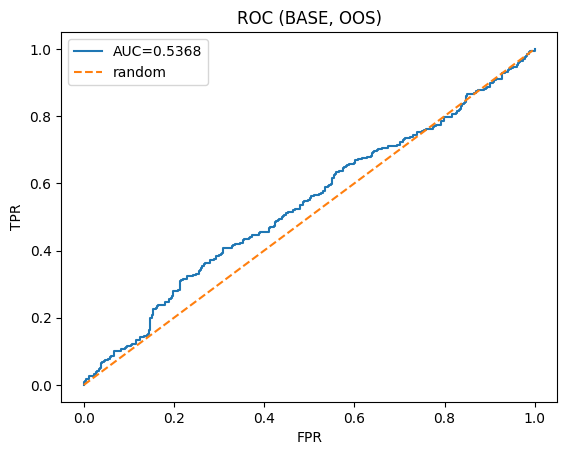

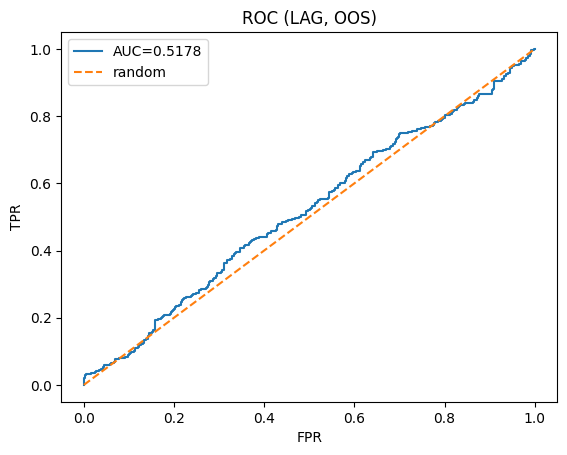

AUC BASE: 0.5368234972582268
AUC LAG : 0.5177561072053685


In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def oos_proba_logreg(df: pd.DataFrame, features: list[str], target: str = "y_up_1d", n_splits: int = 5):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.sort_values("date", kind="stable").reset_index(drop=True)

    X = d[features].copy()
    y = pd.to_numeric(d[target], errors="coerce")

    m = y.notna() & X.notna().any(axis=1)
    X, y = X.loc[m].reset_index(drop=True), y.loc[m].astype(int).reset_index(drop=True)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=3000, class_weight="balanced")),
    ])

    proba_oos = np.full(len(X), np.nan)
    for train_idx, test_idx in tscv.split(X):
        pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
        proba_oos[test_idx] = pipe.predict_proba(X.iloc[test_idx])[:, 1]

    out = pd.DataFrame({"y": y, "p": proba_oos}).dropna()
    return out["y"].values, out["p"].values


def plot_roc(y, p, title="ROC"):
    auc = roc_auc_score(y, p)
    fpr, tpr, _ = roc_curve(y, p)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="random")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.legend()
    plt.show()
    return auc


y_b, p_b = oos_proba_logreg(df2, base_feats, n_splits=5)
auc_b = plot_roc(y_b, p_b, title="ROC (BASE, OOS)")

y_l, p_l = oos_proba_logreg(df_lag, lag_feats, n_splits=5)
auc_l = plot_roc(y_l, p_l, title="ROC (LAG, OOS)")

print("AUC BASE:", auc_b)
print("AUC LAG :", auc_l)